# <p style="background-color:#052C69;font-family:sans-serif;color:#FFFFFF;font-size:120%;text-align:center;border-radius:10px 10px;">Applied Customer Forecasting: Driving Real Business Impact</p>

**Autor: Marcelo Cruz**<br>
Feel free to contact me. I'll appreciate your feedback! https://www.linkedin.com/in/marcelo-cruz-segura/ <br>
More projects in: https://github.com/CeloCruz

<img src='https://raw.githubusercontent.com/CeloCruz/ForecastingCustomers/main/forecasting_banner.png'>

<a id="1"></a>
# <p style="background-color:#052C69;font-family:sans-serif;color:#FFFFFF;font-size:120%;text-align:left;border-radius:12px 12px;">1. Look at the big picture</p>

## 1.1 Business Understanding
**How does the company expect to benefit from this model?**

Our primary objective is to enhance our forecasting capabilities using machine learning, surpassing human intuition. 

This strategic shift ensures our purchase budgets for the upcoming week are finely tuned across multiple restaurants. By delving into time series data with advanced analytics, we aim to uncover trends, seasonal patterns, and critical business insights often overlooked by traditional methods.

This move from human-centric to machine learning-driven forecasting is more than just precision; it's about minimizing waste, maximizing resource allocation, and creating a more agile business model. From a business perspective, this transformation enables us to proactively adapt to customer demand, optimizing both operations and budgets with data-driven precision

## 1.2 Analytical Approach
In our supervised regression machine learning project, focused on forecasting the number of customers using time series data for the upcoming week, we employ the Mean Absolute Error (MAE) as a key performance measure. The MAE provides a comprehensible quantification of the average size of prediction errors, offering insight into the proximity of our forecasts to actual sales figures.

Our analytical approach involves exploring various models, including ETS, ARMA, SARIMA, and XGBoost. 

**The overarching objective is to minimize the MAE, indicating greater accuracy in our predictions.** Throughout the analysis, we will establish the original predictions as the benchmark, allowing us to assess the relative performance of each model.

<div class="alert alert-warning" role="alert">
    <span style='font-family:sans-serif'>
        <b>Important Note:</b><br>
        <ul>
          In line with mutually agreed terms with the company, I've omitted specific dataset details and insights to respect privacy. However, this publication remains a valuable resource, offering insights into time series forecasting and supervised regression within a business context.
        </ul>
    </span>
</div>

## 1.3 Prepare the enviroment

**Import libraries**

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time
import warnings
import requests
import html5lib
from io import StringIO
import itertools
from bs4 import BeautifulSoup
import scipy.stats as stats

# Statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.stattools import adfuller

# Scikit-Learn & XGBoost
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
import xgboost

**Suppress warnings and display options**

In [101]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [102]:
warnings.filterwarnings('ignore')

<a id="2"></a>
# <p style="background-color:#052C69;font-family:sans-serif;color:#FFFFFF;font-size:120%;text-align:left;border-radius:12px 12px;">2.1 Obtain the data</p>

## 2.1 Load the original data

In [103]:
customers = pd.read_csv('https://raw.githubusercontent.com/CeloCruz/ForecastingCustomers/main/clientes_historico.csv')
previsions = pd.read_csv('https://raw.githubusercontent.com/CeloCruz/ForecastingCustomers/main/previ.csv')
customers.head()

,DÍA,FECHA,CLIENTES_AM,CLIENTES_PM,CLIENTES_TOTAL
0,MIÉRCOLES,2/01/2019,NaN,NaN,380
1,JUEVES,3/01/2019,NaN,NaN,389
2,VIERNES,4/01/2019,NaN,NaN,439
3,SÁBADO,5/01/2019,NaN,NaN,280
4,DOMINGO,6/01/2019,NaN,NaN,253


**Shape and types of the dataset**

In [104]:
customers.shape

(1024, 5)

In [105]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DÍA             1024 non-null   object 
 1   FECHA           1024 non-null   object 
 2   CLIENTES_AM     660 non-null    float64
 3   CLIENTES_PM     660 non-null    float64
 4   CLIENTES_TOTAL  1024 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 40.1+ KB


**First & Last 5 rows**

In [106]:
pd.concat([customers.head(),customers.tail()])

,DÍA,FECHA,CLIENTES_AM,CLIENTES_PM,CLIENTES_TOTAL
0,MIÉRCOLES,2/01/2019,NaN,NaN,380
1,JUEVES,3/01/2019,NaN,NaN,389
2,VIERNES,4/01/2019,NaN,NaN,439
3,SÁBADO,5/01/2019,NaN,NaN,280
4,DOMINGO,6/01/2019,NaN,NaN,253
1019,MIÉRCOLES,18/10/2023,132.0,51.0,183
1020,JUEVES,19/10/2023,79.0,74.0,153
1021,VIERNES,20/10/2023,122.0,145.0,267
1022,SÁBADO,21/10/2023,196.0,186.0,382
1023,DOMINGO,22/10/2023,152.0,46.0,198


**Split the train - test dataset**

In [107]:
# Exclude the last 4 weeks for furher evaluation
train_final = customers.iloc[:-28,:].copy()
test_final = customers.iloc[-28:,:].copy()

# Let's make a copy to manipulate it
train_df = customers.iloc[:-28,:].copy()

print('Days in the train dataset: ', len(train_final))
print('Days in the test dataset: ', len(test_final))

Days in the train dataset:  996
Days in the test dataset:  28


**Let's apply some initial changes to the dataset**

In [108]:
def reformat(df):
    """
    Rename columns, translate day column to english
    and date column to datetime
    """
    english_cols = ['dayofweek','date','customers_am','customers_pm','num_customers']
    df.columns = english_cols
    
    week_days = {'lunes': 0,
               'martes': 1,
               'miércoles': 2,
               'jueves': 3,
               'viernes': 4,
               'sábado': 5,
               'domingo': 6
               }   
   
    # format changes
    df['dayofweek'] = pd.Categorical(df['dayofweek'].str.lower().map(week_days))
    df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
    df.set_index('date', inplace=True)
    return df

train_df = reformat(train_df)
train_df.head(3)

,dayofweek,customers_am,customers_pm,num_customers
date,,,,
2019-01-02,2,NaN,NaN,380
2019-01-03,3,NaN,NaN,389
2019-01-04,4,NaN,NaN,439


**Days in the dataset for each year**

In [109]:
train_df.groupby(train_df.index.year)['dayofweek'].count()

date
2019    364
2022    365
2023    267
Name: dayofweek, dtype: int64

<div class="alert alert-warning" role="alert">
    <span style='font-family:sans-serif'>
        <b>Note:</b><br>
        <ul>
          It's essential to note that our dataset covers the period from the beginning of 2019 to October 2023,
with a significant gap between 2019 and 2022. This gap exists because the data for 2020 and 2021 were significantly
impacted by the COVID-19 pandemic, which disrupted the typical behavior of customers. Consequently, relying on this
period for analysis and future forecasting may introduce bias and isn't a robust reference point.
        </ul>
    </span>
</div>

<div class="alert alert-info" role="alert">
    <span style='font-family:sans-serif'>
        <b>Insights:</b><br>
        <ul>
            <li>The column formats are correct.</li>
            <li>We have data spanning 1024 days in the dataset.</li>
            <li>The dataset covers the period from 2019-01-02 to 2023-10-22, revealing a significant gap between these years.</li>
            <li>Four columns share the same amount of missing values.</li>
        </ul>
        <b>Does the dataset capture all the crucial events necessary to address the business questions effectively?</b><br>Given the current constraints of our dataset, we plan to enhance our data analysis by incorporating web scraping, conducting online research, and leveraging feature engineering to augment the depth of our insights.
    </span>
</div>


## 2.2 Obtain more data

We're looking to gather extra data like holidays, temperature, and rainfall from the
internet using web scraping. With this added information, we'll enhance our dataset by
creating new features. This will help us better understand how these external factors relate
to our main focus. By doing this, we can make smarter decisions in our analysis.

**Create new columns with external factors**<br><br>
Check out the holidays in Madrid since that's where our business is based.

In [110]:
official_holidays = [
    '2019-01-01',  '2019-01-06',  '2019-04-18', '2019-04-19', '2019-05-01', 
    '2019-05-02', '2019-05-15', '2019-08-15',  '2019-10-12',  '2019-11-01',  
    '2019-12-06',  '2019-12-08',  '2019-12-25', '2022-01-01',  '2022-01-06',  '2022-04-14', '2022-04-15',
    '2022-05-01', '2022-05-16', '2022-05-02', '2022-07-25', '2022-08-15',
    '2022-10-12', '2022-11-01', '2022-11-09', '2022-12-06', '2022-12-08',
    '2022-12-26', '2023-01-01', '2023-01-06',  '2023-03-20',  '2023-04-06', 
    '2023-04-07',  '2023-05-01',  '2023-05-02', '2023-05-15',  '2023-08-15',  
    '2023-10-12',  '2023-11-01',  '2023-12-06', '2023-12-08',  '2023-11-09',  
    '2023-12-25' 
    ]
other_holidays = [
    '2019-03-19','2019-05-05','2019-10-31','2019-10-31','2019-12-25',
    '2022-03-19','2022-05-01','2022-10-31','2022-12-25','2023-03-19',
    '2023-05-07','2023-10-31'
]
carnivals = [
    '2023-02-16','2023-02-17', '2023-02-18', '2023-02-19','2023-02-20','2023-02-21',
    '2023-02-22','2022-02-25','2022-02-26','2022-02-27','2022-02-28','2022-03-01',
    '2022-03-02','2019-03-01', '2019-03-02','2019-03-03','2019-03-04','2019-03-05'
    ]
prides = [
    '2019-07-01','2019-07-02','2019-07-03','2019-07-04','2019-07-05',
    '2019-07-06','2019-07-07','2019-07-08','2019-07-09','2019-07-10',
    '2022-07-01','2022-07-02','2022-07-03','2022-07-04','2022-07-05',
    '2022-07-06','2022-07-07','2022-07-08','2022-07-09','2022-07-10',
    '2023-06-25','2023-06-26','2023-06-27','2023-06-28','2023-06-29',
    '2023-06-30','2023-07-01','2023-07-02',
]

is_holiday = official_holidays + other_holidays + carnivals + prides
other_holiday = other_holidays + carnivals + prides

def create_holidays_columns(df):
    df['is_official_holiday'] = np.where(df.index.isin(official_holidays),1,0)
    df['is_other_holiday'] = np.where(df.index.isin(other_holiday),1,0)
    df['is_holiday'] = np.where(df.index.isin(is_holiday),1,0)
    df['next_day'] = df.index + pd.DateOffset(days=1)
    df['is_holiday_eve'] = np.where(df.next_day.isin(official_holidays),1,0)
    df.drop('next_day', axis=1, inplace=True)
    return df

create_holidays_columns(train_df);

**Web Scraping for weather data collection**

In [111]:
years = ['2019', '2022', '2023']
months = ['0' + str(x) for x in range(1,10)] + ['10','11','12']

url_start = 'https://www.tutiempo.net/clima/'
url_final = '/ws-82210.html'
weather = pd.DataFrame(columns=['date','T','RA'])

for year in years:
    for month in months:
        url = f'{url_start}{month}-{year}{url_final}'
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            table = soup.findAll('table')
            if len(table) >= 3:
                df_temp = pd.read_html(StringIO(str(table)))[2]
                df_temp['date'] = df_temp["Día"].apply(lambda x: f'{year}-{month}-{x}' if len(str(x)) > 1 else f'{year}-{month}-0{x}')
                weather = pd.concat([weather, df_temp[['date', 'T', 'RA']]], ignore_index=True)
            else:
                print(f"The web {url} doesn't have the expected structure.")
        else:
            print(f'Error trying to access to {url}')

weather

Error trying to access to https://www.tutiempo.net/clima/12-2023/ws-82210.html


,date,T,RA
0,2019-01-01,3.3,NaN
1,2019-01-02,2.3,NaN
2,2019-01-03,3.4,NaN
3,2019-01-04,NaN,NaN
4,2019-01-05,NaN,NaN
...,...,...,...
1129,2023-11-28,-,-
1130,2023-11-29,-,-
1131,2023-11-30,-,-
1132,2023-11-Medias y totales mensuales:,Medias y totales mensuales:,Medias y totales mensuales:


<div class="alert alert-warning" role="alert">
    <span style='font-family:sans-serif'>
        <b>Clean the data before merging it:</b><br>
        <ul>
            <li>There's some incorrect information that was collected during the web scraping process.</li>
            <li>Missing values in the dataset.</li>
            <li>Some dates that fall outside the range of the original dataset.</li>
        </ul>
    </span>
</div>

**Clean the new data and merge both datasets**

In [112]:
# Drop rows with incorrect info
weather['date'] = weather['date'].apply(lambda x: 1 if 'Medias' in x or 'nan' in x else x)
weather = weather.loc[weather.date != 1, :]
weather['T'] = weather.loc[:,'T'].replace('-',np.nan).astype(float)
weather['RA'] = weather.loc[:,'RA'].apply(lambda x: 1 if x == 'o' else 0)

# Keep only rows until 2023-09
weather = weather.loc[weather.date < '2023-09',:][1:]

# Fill missing values for temperature with the mean of the 3 days before
while weather.isnull().sum().sum() > 0:
    weather.loc[:,'T'].fillna(weather['T'].rolling(window=3, min_periods=1).mean(), inplace=True)
    weather.loc[:,'RA'].fillna(0, inplace=True)

weather['date'] = pd.to_datetime(weather['date'])
weather.set_index('date', inplace=True)
                  
print('#Number of days:',len(weather))
print('Number of missing values: ',weather.isnull().sum())

# Merge both datasets
train_df = pd.merge(train_df, weather, how='left', left_index=True, right_index=True)
train_df.rename(columns={'T':'avg_temp', 'RA':'is_raining'}, inplace=True)
train_df['avg_temp'] = np.round(train_df.loc[:,'avg_temp'],2)

#Number of days: 972
Number of missing values:  T     0
RA    0
dtype: int64


**Season column**<br>
Create a column with the seasons of the year.

In [113]:
def add_season_column(df):
    def season(date):
        if datetime(date.year, 3, 20) <= date < datetime(date.year, 6, 21):
            return 0
        elif datetime(date.year, 6, 21) <= date < datetime(date.year, 9, 22):
            return 1
        elif datetime(date.year, 9, 22) <= date < datetime(date.year, 12, 21):
            return 2
        else:
            return 3
    seasons = df.reset_index()
    seasons = seasons.iloc[:,0].apply(season)
    seasons.index = df.index
    df['season'] = seasons
    return df

add_season_column(train_df);

## 2.3 Inspect the data

In [114]:
train_df.head()

,dayofweek,customers_am,customers_pm,num_customers,is_official_holiday,is_other_holiday,is_holiday,is_holiday_eve,avg_temp,is_raining,season
date,,,,,,,,,,,
2019-01-02,2,NaN,NaN,380,0,0,0,0,2.30,0.0,3
2019-01-03,3,NaN,NaN,389,0,0,0,0,3.40,0.0,3
2019-01-04,4,NaN,NaN,439,0,0,0,0,2.85,0.0,3
2019-01-05,5,NaN,NaN,280,0,0,0,1,3.40,0.0,3
2019-01-06,6,NaN,NaN,253,1,0,1,0,3.12,0.0,3


**Dataframe stats**

In [115]:
train_df.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99])

,customers_am,customers_pm,num_customers,is_official_holiday,is_other_holiday,is_holiday,is_holiday_eve,avg_temp,is_raining,season
count,632.000000,632.000000,996.000000,996.000000,996.000000,996.000000,996.000000,972.000000,972.000000,996.000000
mean,99.245253,45.909810,190.270080,0.036145,0.056225,0.090361,0.035141,16.447840,0.226337,1.415663
std,26.796202,32.056009,88.547397,0.186744,0.230471,0.286843,0.184228,8.460703,0.418675,1.147388
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
1%,22.240000,0.000000,64.800000,0.000000,0.000000,0.000000,0.000000,2.055000,0.000000,0.000000
5%,59.550000,6.550000,90.000000,0.000000,0.000000,0.000000,0.000000,4.241000,0.000000,0.000000
25%,82.000000,23.000000,126.000000,0.000000,0.000000,0.000000,0.000000,9.075000,0.000000,0.000000
50%,100.500000,36.000000,170.000000,0.000000,0.000000,0.000000,0.000000,16.010000,0.000000,1.000000
75%,118.000000,66.000000,236.000000,0.000000,0.000000,0.000000,0.000000,23.300000,0.000000,3.000000
95%,138.000000,112.000000,380.000000,0.000000,1.000000,1.000000,0.000000,30.436000,1.000000,3.000000


<div class="alert alert-info" role="alert">
    <span style='font-family:sans-serif'>
        <b>Insights:</b><br>
        <ul>
            <li>We could notice some days with zero customers in the dataset</li>
            <li>Missing values in the dataset (customers_am & customers_pm).</li>
        </ul>
    </span>
</div>

**Days with zero customers**

In [116]:
train_df.loc[train_df.num_customers == 0,:]

,dayofweek,customers_am,customers_pm,num_customers,is_official_holiday,is_other_holiday,is_holiday,is_holiday_eve,avg_temp,is_raining,season
date,,,,,,,,,,,
2019-12-25,2,NaN,NaN,0,1,1,1,0,7.70,0.0,3
2023-04-16,6,0.0,0.0,0,0,0,0,0,15.75,0.0,0


* On December 25, 2019, the restaurant was closed for Christmas.

* On April 16, 2023, the restaurant was closed due to flooding.

**Explore the rest of missing values**

In [117]:
# All the missing values except the above rows
missing = train_df.loc[:,:'is_holiday_eve'] # Excluding columns generated
missing = missing[(missing['num_customers'] != 0) & (missing.isnull().sum(axis=1) > 0)] # Rows with missing vlaues except in num_customers
pd.concat([missing.head(),missing.tail()])

,dayofweek,customers_am,customers_pm,num_customers,is_official_holiday,is_other_holiday,is_holiday,is_holiday_eve
date,,,,,,,,
2019-01-02,2,NaN,NaN,380,0,0,0,0
2019-01-03,3,NaN,NaN,389,0,0,0,0
2019-01-04,4,NaN,NaN,439,0,0,0,0
2019-01-05,5,NaN,NaN,280,0,0,0,1
2019-01-06,6,NaN,NaN,253,1,0,1,0
2019-12-27,4,NaN,NaN,492,0,0,0,0
2019-12-28,5,NaN,NaN,461,0,0,0,0
2019-12-29,6,NaN,NaN,402,0,0,0,0
2019-12-30,0,NaN,NaN,412,0,0,0,0


*Hypothesis:*
* It appears that all the missing data corresponds to the year 2019 and is concentrated in the same columns:
`customer_am` and `customers_pm`. The most plausible explanation is that during that time,
we didn't track with such granularity, which means we lack detailed information about the differences in customer
behavior between lunch and dinner times.

In [118]:
days_zero_custom = missing.loc[missing.index.year != 2019,:].count().sum()
print('Days with null values (excluding generated columns and days with zero customers): ',days_zero_custom)

Days with null values (excluding generated columns and days with zero customers):  0


**What have in common the 5th percentile of `num_customers`?**

In [119]:
train_df.query('num_customers < num_customers.quantile(.05)');

<div class="alert alert-info" role="alert">
    <span style='font-family:sans-serif'>
        <b>Insights:</b><br>
        <ul>
            We observed that in 2022, there were multiple occasions when the night service was suspended, particularly on non-weekend days. This decision was primarily due to the lingering effects of post-Covid restrictions, which limited nighttime operations and made it financially unviable to operate on those specific days. We do not intend to delete these records; however, it would be beneficial to include a column indicating whether a particular day had a suspended service or not.
        </ul>
    </span>
</div>

**Data Manipultion & Feature Engineering**

In [120]:
def service_closed(df):
    # Drop days with zero customers
    df.drop(df.loc[df.num_customers == 0].index, axis=0, inplace=True)
    
    # One service closed excluding 2019
    closed = np.where(df.index.year > 2019, 
                      np.where((df.customers_am > 0) & (df.customers_pm > 0),0,1),
                      0
                     )
    df['one_service_closed'] = closed
    
    return df

def temporal_features(df):
    """ Create columns with time features"""
    # Time features
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    df['dayofyear'] = df.index.dayofyear
    df['year'] = df.index.year
    return df

def outliers_treatment(df):
    """Replace services closed with the average
    number of customers"""
    service_closed = df.query('one_service_closed == 1')
    # Average num_customers for days with both services opened
    customers_am_mean = df.query('one_service_closed == 0')['customers_am'].mean()
    customers_pm_mean = df.query('one_service_closed == 0')['customers_pm'].mean()

    service_closed['customers_am'] = service_closed['customers_am'].replace(0, customers_am_mean)
    service_closed['customers_pm'] = service_closed['customers_pm'].replace(0, customers_pm_mean)
    service_closed['num_customers'] = service_closed.loc[:,['customers_am','customers_pm']].sum(1)
    
    return df

<a id="3"></a>
# <p style="background-color:#052C69;font-family:sans-serif;color:#FFFFFF;font-size:120%;text-align:left;border-radius:12px 12px;">3. Exploratory Data Analysis & Feature Engineering</p>

**Let's make a copy**

In [121]:
train_df = service_closed(train_df)
train_df = temporal_features(train_df)

**Style and plot functions**

In [122]:
sns.set_theme(context= 'notebook')
sns.set_style('dark')
sns.set(rc={'axes.grid':False})
sns.set_palette('Blues_r')

In [123]:
def num_plot(df, col):
  """Graph an histogram with a boxplot above
	for one numerical column"""
  fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,4),gridspec_kw={"height_ratios": (.2, .8)})
  sns.boxplot(x=col, data=df, ax=ax[0])
  ax[0].set_xlabel(None)
  ax[0].set(yticks=[])
  sns.histplot(x=col, data=df, ax=ax[1])
  ax[1].set_xlabel(col.replace('_',' ').title(), fontsize=22, loc= 'left')
  plt.axvline(df[col].mean(), color='#25544f', linewidth=2.2, label='mean=' + str(np.round(df[col].mean(),1)))
  plt.axvline(df[col].median(), color='#6c8b87', linewidth=2.2, label='median='+ str(np.round(df[col].median(),1)))
  plt.axvline(df[col].mode()[0], color='#4db1a6', linewidth=2.2, label='mode='+ str(df[col].mode()[0]))
  plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fontsize=10, fancybox=True, shadow=True, frameon=True)
  plt.tight_layout()
  return ax 

## 3.1 Target variable

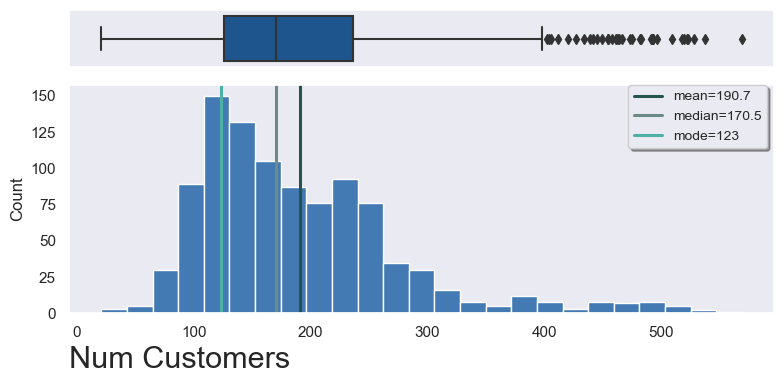

In [124]:
num_plot(train_df, 'num_customers')
plt.show()

**Differences between Lunch and Dinner**

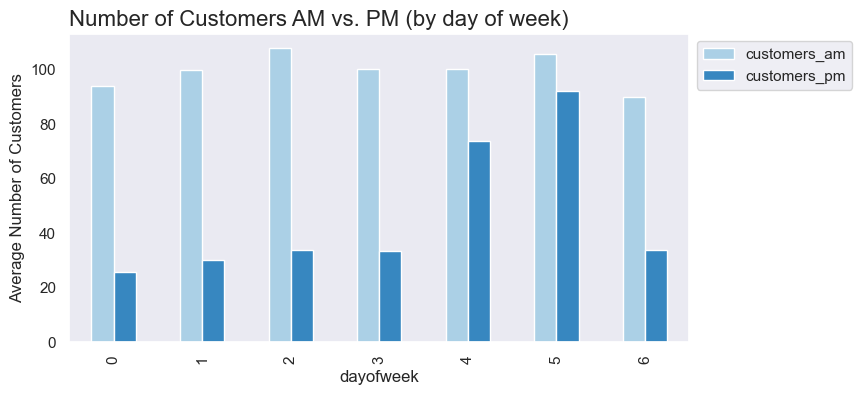

In [125]:
palette = sns.cubehelix_palette(start=2.5, rot=.17, reverse=True, as_cmap=True)
palette

fig, ax = plt.subplots(figsize=(8,4))
grouped_by_day = train_df.groupby('dayofweek')[['customers_am','customers_pm']].mean()
grouped_by_day.plot(kind='bar', color=sns.color_palette('Blues',2),
                         ylabel='Average Number of Customers', ax=ax)
plt.title('Number of Customers AM vs. PM (by day of week)', size=16, loc='left')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

<div class="alert alert-info" role="alert">
    <span style='font-family:sans-serif'>
        <b>Insights:</b><br>
        <ul>
            <li>With the exception of Fridays and Saturdays, there is a noteworthy contrast in the number of
customers between lunch and dinner, with a difference drawing nearly three times as many patrons.</li>
            <li>During lunchtime, the average number of customers remains fairly consistent across most days of the week.</li>
            <li>The primary reason for the higher customer count on Fridays and Saturdays is predominantly due to the evening crowd.</li>
            <li>Interestingly, Wednesdays boast the highest average attendance during the lunchtime service.</li>
        </ul>
    </span>
</div>

## 3.2 Exploring the impact of other factors

**Meteoroligical factors**

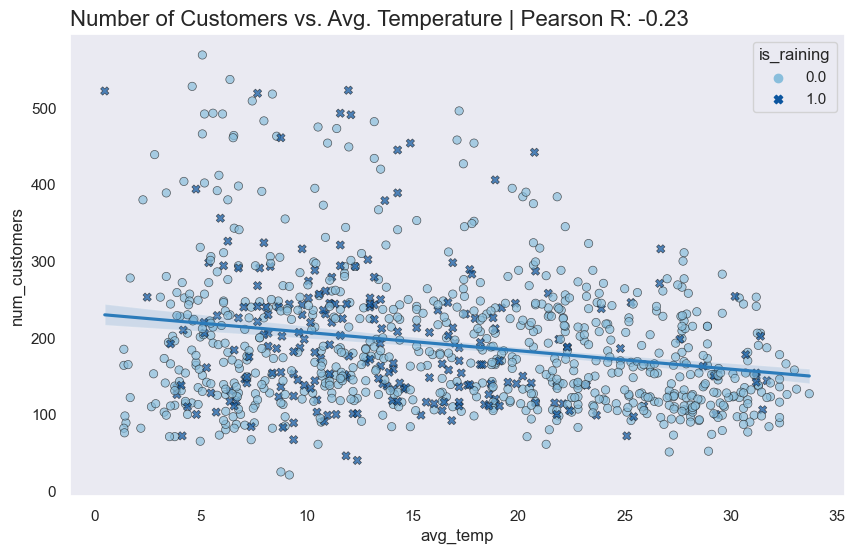

In [126]:
fig, ax = plt.subplots(figsize=(10, 6))

corr_temp_customers = train_df.corr().loc['num_customers','avg_temp']

sns.scatterplot(data=train_df, x='avg_temp', y='num_customers',
                hue='is_raining', 
                palette=['#89bedc','#0b559f'], 
                markers=True,
                alpha=0.7, 
                edgecolor='k',
                style='is_raining')

sns.regplot(data=train_df, x='avg_temp', y='num_customers', scatter=False, color='#2b7bba')

plt.title(f'Number of Customers vs. Avg. Temperature | Pearson R: {corr_temp_customers:.2f}', size=16, loc='left')
plt.show()

<div class="alert alert-info" role="alert">
    <span style='font-family:sans-serif'>
        <b>Insights:</b><br>
        <ul>
            <li> It's noticeable that on days when the average temperature exceeds 20 degrees, we don't observe days with a
high number of customers. This aligns with our earlier analysis, which indicated that summer experiences lower
                attendance rates.</li>
            <li> Interestingly, it appears that rainy weather doesn't have a significant impact on the number of customers.</li>
        </ul>
    </span>
</div>

**Holidays**

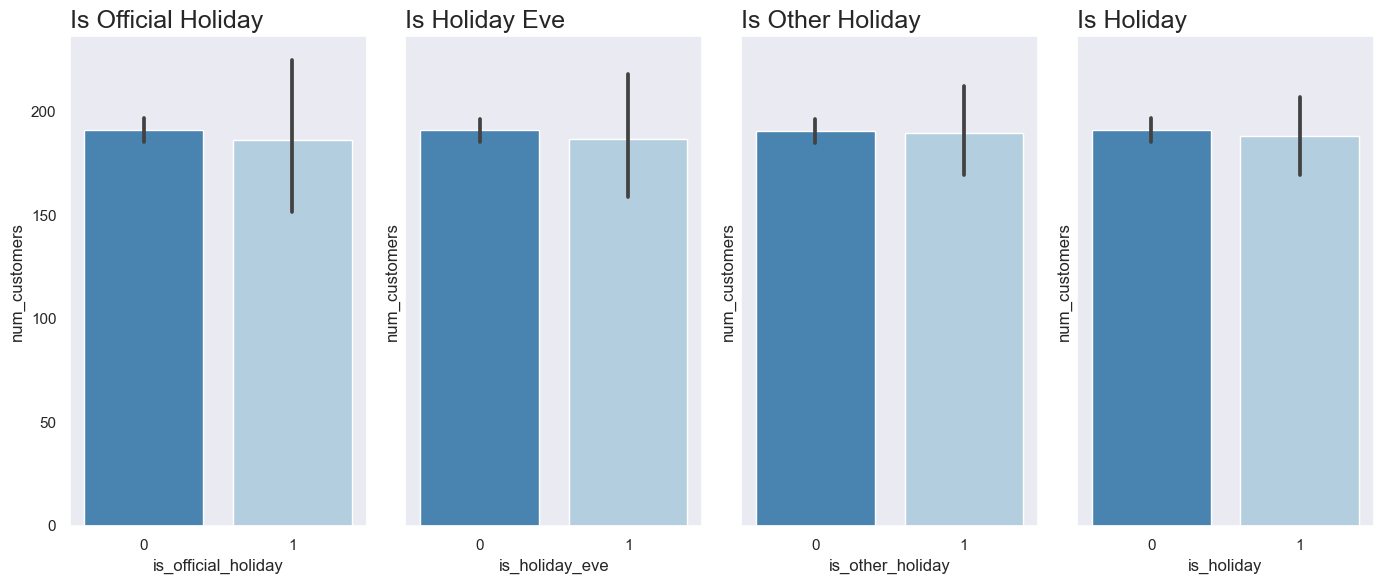

In [127]:
categories = ['is_official_holiday', 'is_holiday_eve', 'is_other_holiday', 'is_holiday']

fig, ax = plt.subplots(1, 4, figsize=(14, 6), sharey=True)

for i, category in enumerate(categories):
    sns.barplot(data=train_df, x=category, y='num_customers',
               palette='Blues_r', ax=ax[i])
    ax[i].set_title(categories[i].replace('_',' ').title(), size=18, loc='left')

plt.tight_layout()
plt.show()

In [128]:
for column in categories:
    formula = f'num_customers ~ {column}'
    model = ols(formula, data=train_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    print(f"ANOVA results for {column}:")
    print(anova_table)
    print("\n")

ANOVA results for is_official_holiday:
                           sum_sq     df         F    PR(>F)
is_official_holiday  6.473733e+02    1.0  0.083097  0.773204
Residual             7.728240e+06  992.0       NaN       NaN


ANOVA results for is_holiday_eve:
                      sum_sq     df         F    PR(>F)
is_holiday_eve  6.213687e+02    1.0  0.079759  0.777683
Residual        7.728266e+06  992.0       NaN       NaN


ANOVA results for is_other_holiday:
                        sum_sq     df         F   PR(>F)
is_other_holiday  8.109377e+01    1.0  0.010408  0.91876
Residual          7.728806e+06  992.0       NaN      NaN


ANOVA results for is_holiday:
                  sum_sq     df         F    PR(>F)
is_holiday  5.763631e+02    1.0  0.073982  0.785682
Residual    7.728311e+06  992.0       NaN       NaN




<div class="alert alert-info" role="alert">
    <span style='font-family:sans-serif'>
        <b>Insights:</b><br>
        <ul>
            <li>Holidays in Madrid generally result in fewer customers, with a slight uptick on the eve of holidays. However, the difference in attendance is not statistically significant, as indicated by higher p-values for each column.</li>
        </ul>
    </span>
</div>

**Long Weekends**

To clarify my current actions, I'm conducting feature engineering to test a hypothesis:<br>

* If a holiday falls on a Monday, Tuesday, Thursday, or Friday, I'll treat the entire weekend leading up to that holiday as a "long weekend". This is because many companies offer the opportunity to take a day off or work remotely, so a lot of people seize the chance for a short trip. This could potentially impact attendance.

* There's a unique situation when a holiday falls on a Wednesday and is also accompanied by another day off during the week. In this case, it extends into an even longer "weekend."

In [129]:
def create_long_weekend(df):
    # Crear temp variables
    df['is_weekend'] = np.where(df.dayofweek.isin([5, 6]), 1, 0)
    
    df['near_holiday'] = np.where((df.dayofweek.isin([0, 1, 3, 4])) & (df.is_official_holiday == 1), 1, 0)
    
    df['bridge'] = np.where(((df.dayofweek == 0) & (df.shift(-1).near_holiday == 1)) |\
                            ((df.dayofweek == 4) & (df.shift(1).near_holiday == 1)), 1, 0)
    
    df['special_wed'] = np.where(((df.dayofweek == 2) & (df.is_official_holiday == 1)) & \
                                 ((df.shift(1).is_official_holiday == 1) | \
                                  (df.shift(2).is_official_holiday == 1) | \
                                  (df.shift(-1).is_official_holiday == 1) | \
                                  (df.shift(-2).is_official_holiday == 1)), 1, 0)
    
    df['special_bridge'] = np.where((df.is_weekend == 0) & ((df.shift(1).special_wed == 1) \
                                                            | (df.shift(2).special_wed == 1) \
                                                            | (df.shift(-1).special_wed == 1) \
                                                            | (df.shift(-2).special_wed == 1)) \
                                    & ((df.shift(1).near_holiday == 1) | (df.shift(-1).near_holiday == 1)), 1, 0)
    
    # Crear other temp variables
    df['add_to_weekend'] = df[['near_holiday', 'bridge', 'special_wed', 'special_bridge']].max(axis=1)
    df['special_weekends'] = np.where((df.is_weekend == 1) & ((df.shift(1).add_to_weekend == 1) | \
                                                              (df.shift(-1).add_to_weekend == 1) | \
                                                              (df.shift(2).add_to_weekend == 1) | \
                                                              (df.shift(-2).add_to_weekend == 1)), 1, 0)
    df['long_weekends'] = df[['add_to_weekend', 'special_weekends']].sum(axis=1)
    
    # Drop unnecesary columns
    cols = ['is_weekend','near_holiday','bridge','special_wed','special_bridge','add_to_weekend','special_weekends']
    df.drop(cols, axis=1, inplace=True)
    return df

train_df = create_long_weekend(train_df)

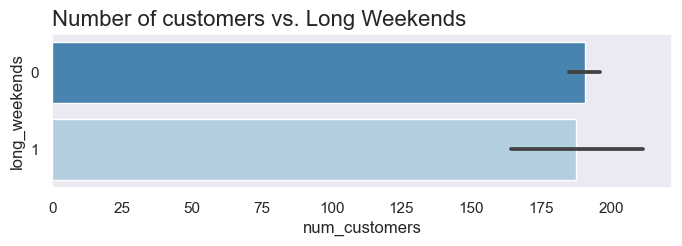

In [130]:
fig, ax = plt.subplots(figsize=(8,2))

sns.barplot(data=train_df, x='num_customers', y='long_weekends',
           orient='h', ax=ax, palette='Blues_r')
plt.title('Number of customers vs. Long Weekends', size=16, loc='left')
plt.show()

**One Service Closed**

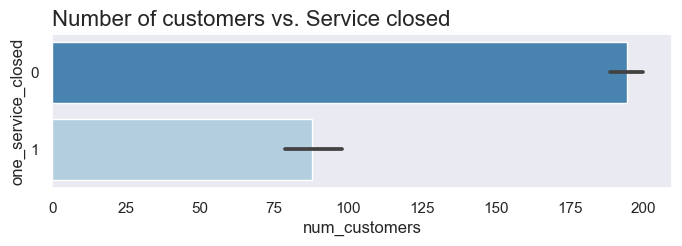

In [131]:
fig, ax = plt.subplots(figsize=(8,2))

sns.barplot(data=train_df, x='num_customers', y='one_service_closed',
           orient='h', ax=ax, palette='Blues_r')

plt.title('Number of customers vs. Service closed', loc='left', size=16)
plt.show()

<div class="alert alert-info" role="alert">
    <span style='font-family:sans-serif'>
        <b>Insights:</b><br>
        <ul>
            <li><b>Long Weekends.</b> There's no a substantial difference between groups.</li>
            <li><b>One Service Closed.</b> It's clearly a significant difference between groups</li>
        </ul>
    </span>
</div>

## 3.3 Explore time features

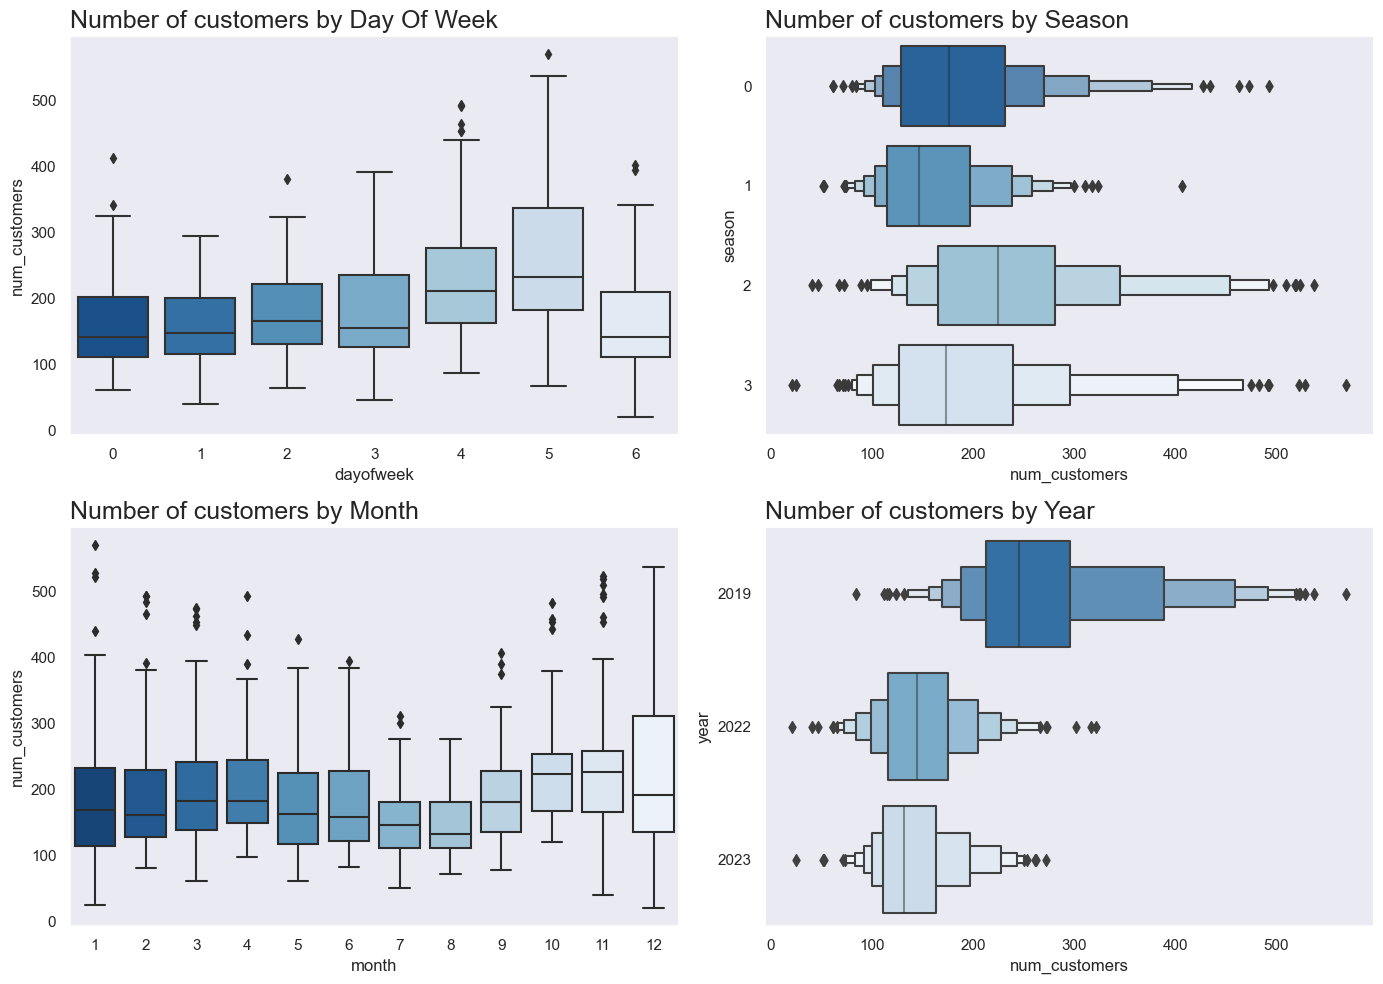

In [132]:
fig, ax = plt.subplots(2,2, figsize=(14,10))

sns.boxplot(data=train_df, x='dayofweek', y='num_customers', 
                palette=sns.color_palette('Blues_r', len(train_df['dayofweek'].unique())),
                ax=ax[0,0])
ax[0,0].set_title('Number of customers by Day Of Week', size=18, loc='left')
sns.boxplot(data=train_df, x='month', y='num_customers', 
                palette=sns.color_palette('Blues_r', len(train_df['month'].unique())),
                ax=ax[1,0])
ax[1,0].set_title('Number of customers by Month', size=18, loc='left')
sns.boxenplot(data=train_df, x='num_customers', y='season',
                palette=sns.color_palette('Blues_r', len(train_df['season'].unique())),
                ax=ax[0,1], orient='h')
ax[0,1].set_title('Number of customers by Season', size=18, loc='left')
sns.boxenplot(data=train_df, x='num_customers', y='year', orient='h',
                palette=sns.color_palette('Blues_r', len(train_df['year'].unique())),
                ax=ax[1,1])
ax[1,1].set_title('Number of customers by Year', size=18, loc='left')

plt.tight_layout()
plt.show()

In [133]:
for column in ['dayofweek','month','season','year']:
    formula = f'num_customers ~ {column}'
    model = ols(formula, data=train_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    print(f"ANOVA results for {column}:")
    print(anova_table)
    print("\n")

ANOVA results for dayofweek:
                 sum_sq     df          F        PR(>F)
dayofweek  1.520691e+06    6.0  40.294083  5.320242e-44
Residual   6.208197e+06  987.0        NaN           NaN


ANOVA results for month:
                sum_sq     df         F    PR(>F)
month     6.706111e+04    1.0  8.682607  0.003288
Residual  7.661826e+06  992.0       NaN       NaN


ANOVA results for season:
                sum_sq     df          F    PR(>F)
season    1.100784e+05    1.0  14.332651  0.000162
Residual  7.618809e+06  992.0        NaN       NaN


ANOVA results for year:
                sum_sq     df           F         PR(>F)
year      3.426399e+06    1.0  790.005219  2.503842e-128
Residual  4.302488e+06  992.0         NaN            NaN




<div class="alert alert-info" role="alert">
    <span style='font-family:sans-serif'>
        <b>Insights:</b><br>
        <ul>
            <li>Undoubtedly, Friday and Saturday, especially Saturday, stand out as the days of the week with the highest customer turnout.</li>
            <li>Apparently all features may be potential predictors.</li>
            <li> The remaining days of the week seem to attract a fairly consistent number of customers.</li>
            <li>We can clearly see a dip in customer numbers during the summer months, specifically in July and August,<br>
                and a notable surge, along with a wider range, in December.</li>
            <li>Autumn appears to be the season when we experience the highest customer attendance. It's worth noting that most<br>
                days in December fall within the autumn season, which could explain the uptick.</li>
            <li>There's a noticeable contrast between the pre-Covid year of 2019 and the period after 2021. This discrepancy strongly<br>
                suggests that the business has not fully recovered from the impact of the pandemic yet.</li>
        </ul>
    </span>
</div>

## 3.4 Time Series Exploring

Considering the substantial gap between 2019 and 2022 in our data, let's take a closer look at each year individually to see if any seasonal or cyclical patterns emerge in customer traffic.

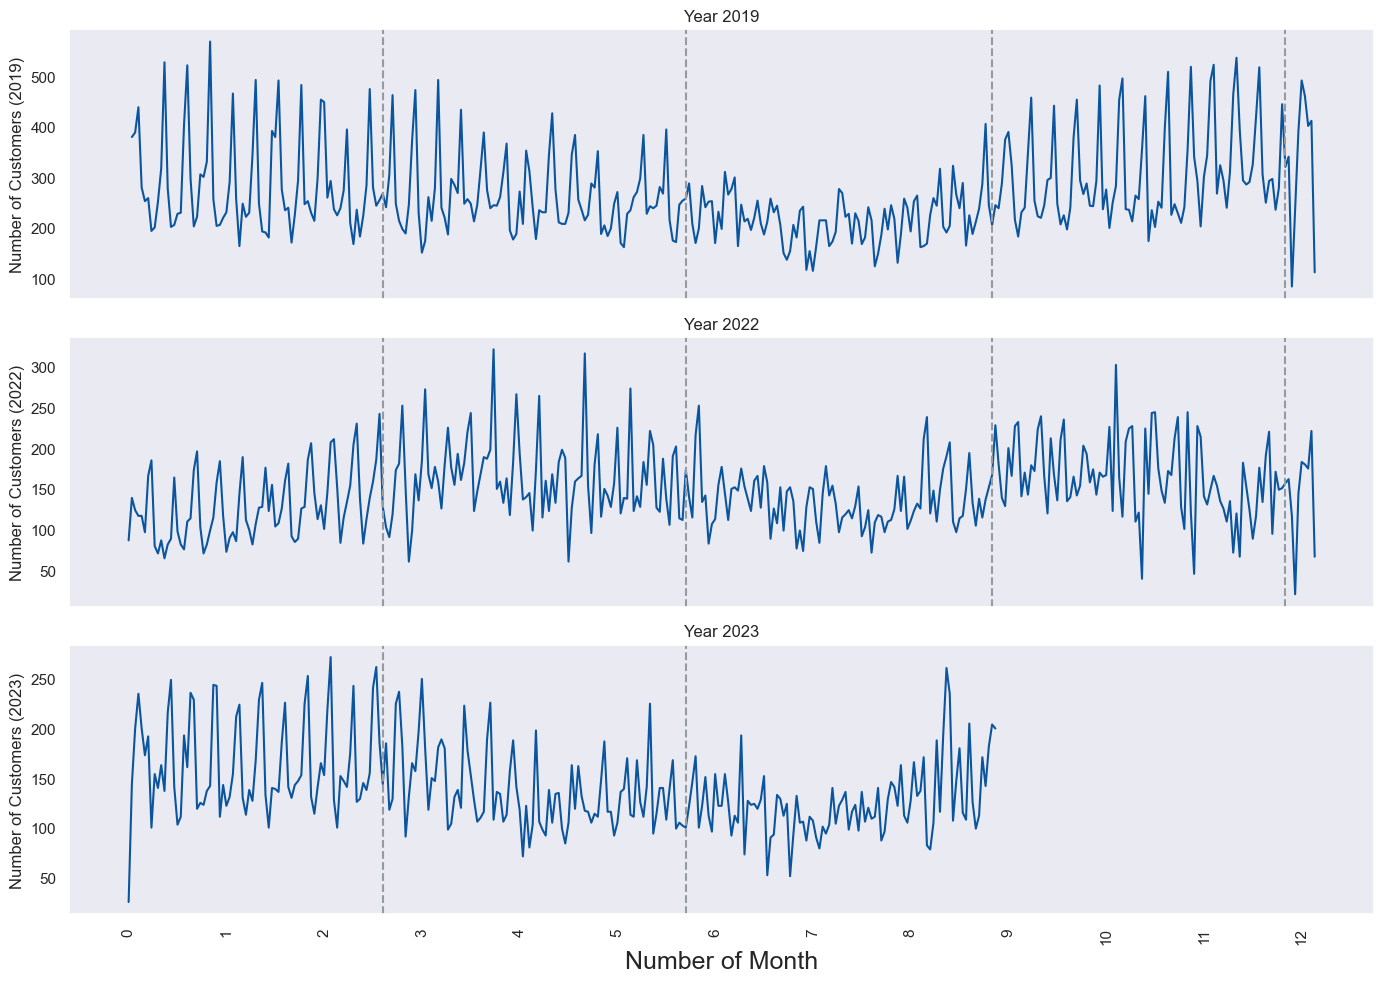

In [134]:
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for i, year in enumerate([2019, 2022, 2023]):
    year_data = train_df.loc[train_df.year == year, :]
    sns.lineplot(data=year_data, x='dayofyear', y='num_customers', ax=ax[i])
    ax[i].set_ylabel(f'Number of Customers ({year})')

ax[-1].set_xticks(range(1, 366, 30))
ax[-1].set_xticklabels([str(month) for month, day in enumerate(range(1, 366, 30))], rotation=90)
ax[-1].set_xlabel('Number of Month', size=18)

seasons = {
    2019: {'Spring': ('2019-03-20', '2019-06-20'),
           'Summer': ('2019-06-21', '2019-09-22'),
           'Autumn': ('2019-09-23', '2019-12-21'),
           'Winter': ('2019-12-22', '2019-03-19')},
    
    2022: {'Spring': ('2022-03-20', '2022-06-20'),
           'Summer': ('2022-06-21', '2022-09-22'),
           'Autumn': ('2022-09-23', '2022-12-21'),
           'Winter': ('2022-12-22', '2022-03-19')},
    
    2023: {'Spring': ('2023-03-20', '2023-06-20'),
           'Summer': ('2023-06-21', '2023-09-22')}
}

for i, year in enumerate([2019, 2022, 2023]):
    year_data = train_df[train_df.year == year]
    for season, (start, final) in seasons[year].items():
        ax[i].axvline(x=year_data[year_data.index == start]['dayofyear'].values[0], color='#959b9f', 
                      linestyle='--', label=f'{season} Start')

    ax[i].set_title(f'Year {year}')

plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert">
    <span style='font-family:sans-serif'>
        <b>Insights:</b><br>
        <ul>
            <li>We confirm some of our previous hypothesis: the range of y-axis for 2019 it's wider due to the higher amount of customers, 
Summer (3rd rectangle) have the lower attendance, and we can appreciate some cycles with peaks and valleys, which correspond
to fridays and saturdays.</li>
            <li>This data looks stationarity.</li>
            <li>Given the substantial discrepancy in customer numbers between 2019 and 2022-2023, coupled with significant structural business changes (ownership, menu, and economic factors), excluding the 2019 data appears justifiable. This decision aligns with the aim of analyzing the current time series dynamics more accurately.</li>
            <li>We can appreciate some days with some outliers values.</li>
        </ul>
    </span>
</div>

### 3.4.1 Augmented Dickey Fuller Test & Seasonal Decomposition

**Augmented Dickey Fuller Test**<br>
* The ADF test helps us assess the stability and predictability of a time series, providing insights into whether the data exhibits a constant behavior or undergoes significant changes over time

In [135]:
# Include all the data available and other test excluding data from 2019
train_limited = train_df[train_df.index.year > 2019]
adf_all = adfuller(train_df.num_customers)
adf_since_2022 = adfuller(train_limited.num_customers)

print('----------- Include all the data')
print(f'Test statistic: {adf_all[0]:.4f}')
print(f'p-value: {adf_all[1]:.4f}')
print('----------- Only data since 2022')
print(f'Test statistic: {adf_since_2022[0]:.4f}')
print(f'p-value: {adf_since_2022[1]:.4f}')


----------- Include all the data
Test statistic: -2.3588
p-value: 0.1537
----------- Only data since 2022
Test statistic: -2.3808
p-value: 0.1472


* The p-value is higher than the typical significance level of 0.05. In this case, we fail to reject the null hypothesis. The test statistic being less negative also supports this interpretation. It suggests that including all the data, the time series might have a unit root, indicating non-stationarity.

**Seasonal Decompose using STL**

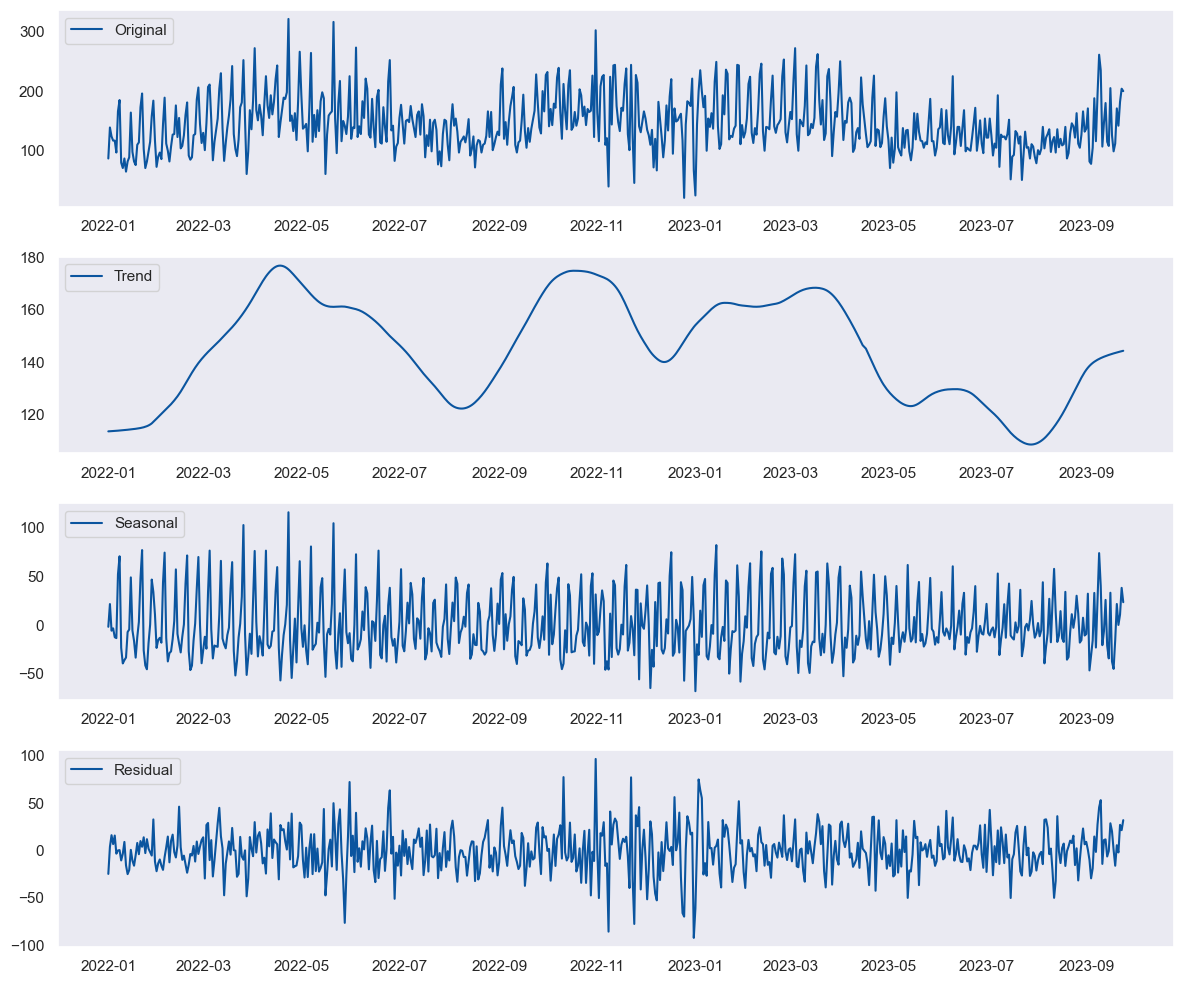

In [136]:
result = STL(endog=train_limited.num_customers,
    period=28,
    trend_deg=0,
    robust=False).fit()

# Plot the decomposition
plt.figure(figsize=(12, 10))

# Original time series
plt.subplot(411)
plt.plot(train_limited.num_customers, label='Original')
plt.legend(loc='upper left')

# Trend component
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

# Seasonal component
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

# Residual component
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### 3.4.2 Lag Features

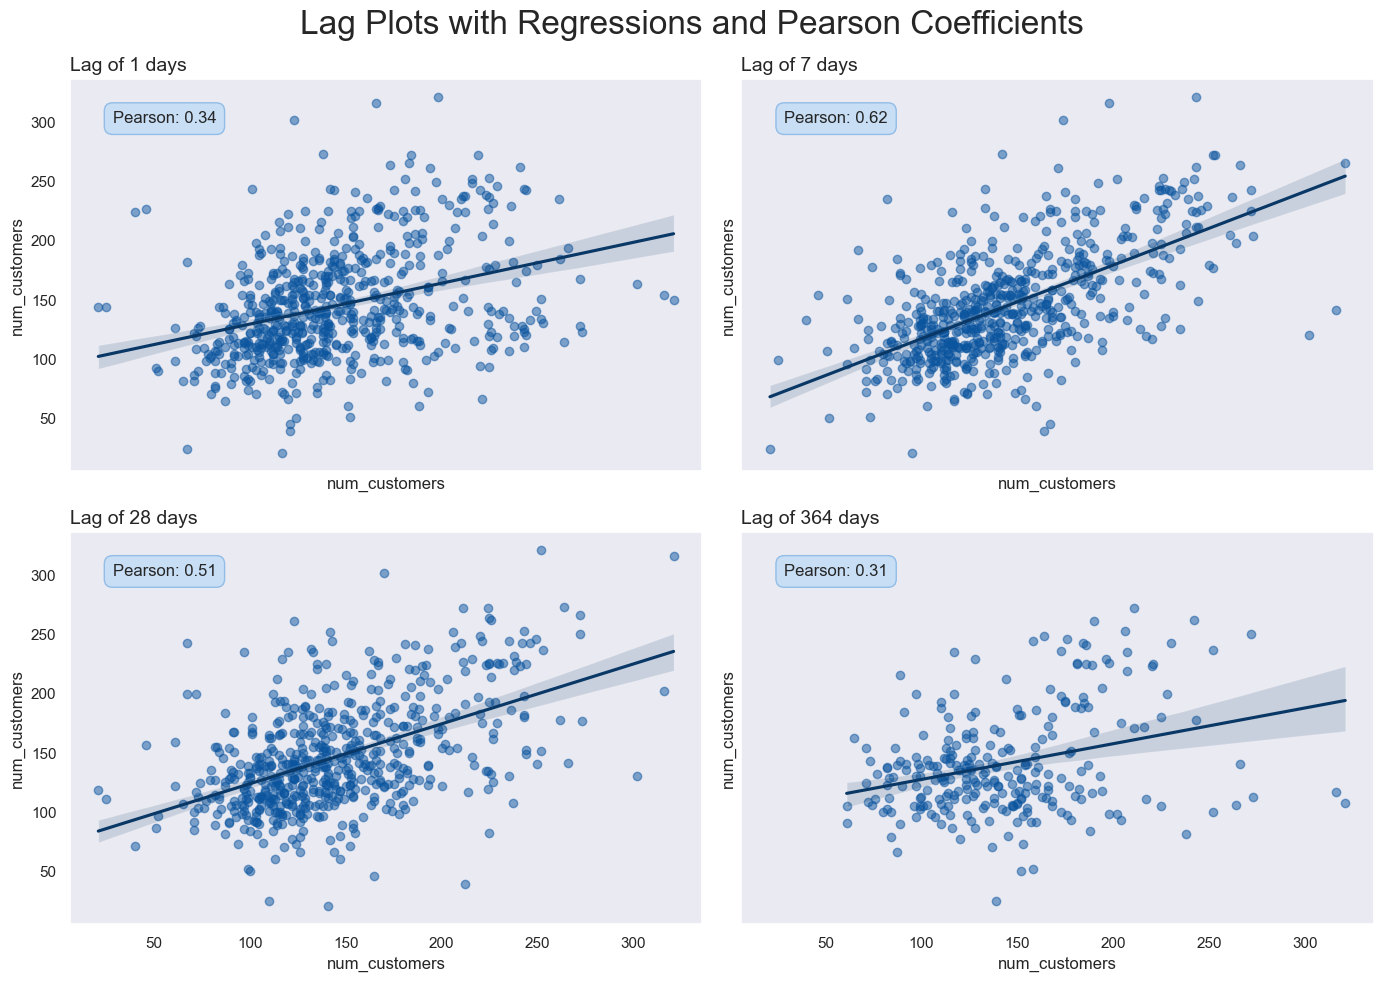

In [137]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10), sharey=True, sharex=True)

lags = [1, 7, 28, 364]

for i, lag in enumerate(lags):
    row, col = i // 2, i % 2
    lag_data = train_limited.num_customers.shift(lag)
    
    pd.plotting.lag_plot(train_limited.num_customers, lag=lag, ax=ax[row, col], alpha=0.5)
    ax[row, col].set_title(f'Lag of {lag} days', size=14, loc='left')
    
    sns.regplot(x=lag_data, y=train_limited.num_customers, 
                scatter=False, color='#093866', ax=ax[row, col])
    
    corr_coefficient = train_limited.num_customers.corr(lag_data)
    ax[row, col].text(0.15, 0.9, f'Pearson: {corr_coefficient:.2f}', 
                      horizontalalignment='center', 
                      verticalalignment='center', 
                      transform=ax[row, col].transAxes,
                      bbox=dict(facecolor='#C7DEF5', edgecolor='#92BDE7', boxstyle='round,pad=0.5'))

plt.suptitle('Lag Plots with Regressions and Pearson Coefficients', size=24)
plt.tight_layout()
plt.show()



<div class="alert alert-info" role="alert">
    <span style='font-family:sans-serif'>
        <b>Insights:</b><br>
        <ul>
            <li>The analysis clearly shows a strong relationship, especially with a one-week lag, followed closely by a four-week lag. </li>
            <li>Additionally, when we apply the Seasonal-Trend decomposition procedure, we observe a noticeable degree of steadiness, particularly when looking at the detrended component in the third plot.</li>
        </ul>
    </span>
</div>

### 3.4.3 Autocorrelation Function & Partial Autocorrelation Function

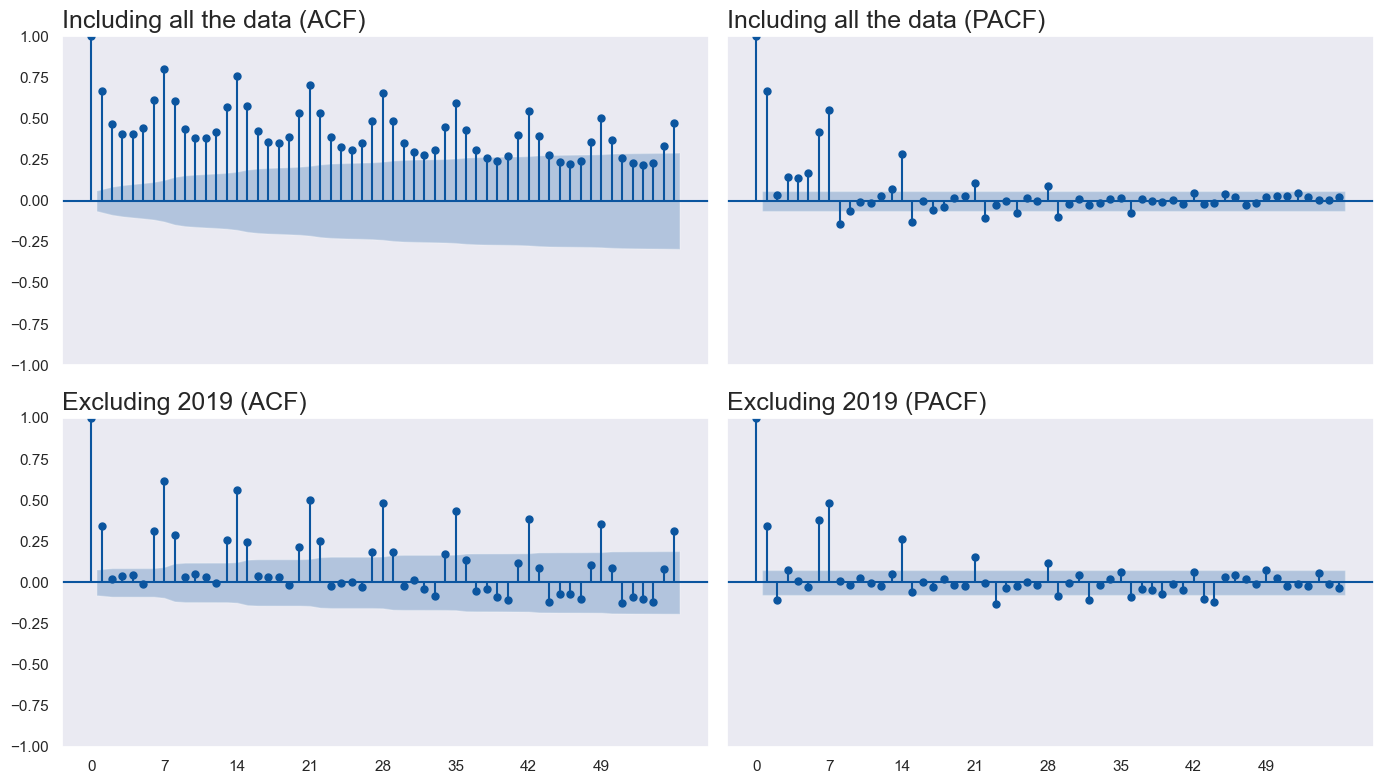

In [138]:
fig, ax = plt.subplots(2,2, figsize=(14,8), sharex=True, sharey=True)

plot_acf(train_df.num_customers, lags=56, ax=ax[0,0], title=None)
ax[0,0].set_title('Including all the data (ACF)', size=18, loc='left')

plot_pacf(train_df.num_customers, lags=56, ax=ax[0,1], title=None)
ax[0,1].set_title('Including all the data (PACF)', size=18, loc='left')

plot_acf(train_limited.num_customers, lags=56, ax=ax[1,0], title=None)
ax[1,0].set_title('Excluding 2019 (ACF)', size=18, loc='left')

plot_pacf(train_limited.num_customers, lags=56, ax=ax[1,1], title=None)
ax[1,1].set_title('Excluding 2019 (PACF)', size=18, loc='left')

plt.xticks(range(0,56,7), range(0,56,7))
plt.tight_layout()
plt.show()

* We notice regular peaks every 7 days, confirming our previous findings. There are also strong connections at other points like lag 1, 6, 8, 13, and so on. 
* To fine-tune our ARMA and SARIMA models for business forecasting, we're focusing on time periods with the best correlations to determine the right "p" and "q" values.

In [139]:
q = [1,6,7,14,21] #ACF
p = [1,6,7,14] #PACF

# Excluding 2019
q_exc = [1,6,7,14] #ACF
p_exc = [1,6,14] #PACF

**Create Lag Features for further modeling**

In [140]:
def lag_features(df):
    """Create some lag features for further modeling"""
    time_map = df['num_customers'].to_dict()
    df['lag_1_days'] = (df.index - pd.Timedelta('1 days')).map(time_map)
    df['lag_6_days'] = (df.index - pd.Timedelta('6 days')).map(time_map)
    df['lag_7_days'] = (df.index - pd.Timedelta('7 days')).map(time_map)
    df['lag_13_days'] = (df.index - pd.Timedelta('13 days')).map(time_map)
    df['lag_14_days'] = (df.index - pd.Timedelta('14 days')).map(time_map)
    df['lag_21_days'] = (df.index - pd.Timedelta('21 days')).map(time_map)
    df['lag_28_days'] = (df.index - pd.Timedelta('28 days')).map(time_map)
    df['lag_84_days'] = (df.index - pd.Timedelta('84 days')).map(time_map)
    df['lag_364_days'] = (df.index - pd.Timedelta('364 days')).map(time_map)
    return df

## 3.5 Window features

In our forecasting model, window features mean focusing on a specific past data interval to predict future values—like using a historical snapshot for reference. It's a way to upgrade the info we provide to the model through feature engineering.


<div class="alert alert-warning" role="alert">
    <span style='font-family:sans-serif'>
        <b>Note:</b><br>
        <ul>
            In forecasting, we need to avoid a common problem called data leakage. This happens when the model accidentally learns from information about the future that it shouldn't know. It's like teaching the model with answers it shouldn't have. Being careful about this helps the model make more accurate predictions based on what it would realistically know at the time.
        </ul>
    </span>
</div>

Here's a breakdown of our feature engineering:

* **avg_last_4_weeks & std_last_4_weeks**: Average and Std for each day of the week over the last four weeks, excluding the current week.
<br>

* **avg_week_before & std_week_before**: Average and Std of the total customer count for the week just before the current one.
<br>

* **rolling_mean**: Average for each day of the week in an ongoing way, updating every week but leaving out the current week.
<br>

* **diff_months & diff_weeks**: We're comparing the average customer count for the entire week before with the week just before that, and doing the same for monthly intervals.

In [141]:
# Some custom functions for feature engineering

def number_of_week(date):
    """Create a column specifying rows that
    belong to the same week"""
    # Create the date range weekly
    week_dates = pd.date_range(start='2018-12-31', end='2025-12-28', freq='W-MON')
    df_weeks = pd.DataFrame({'week_start': week_dates})
    week_start = df_weeks['week_start']
    next_monday = week_start.shift(-1, fill_value=date)
    week = week_start[(date >= week_start) & (date < next_monday)]
    week_number= week.index[0] if not week.empty else None
    return week_number

def window_features(df):
    """ Calculate weekly statistics: 
         - Mean and Std of Previous Week
        - Mean Difference (1 week and 4 weeks)"""
        
    # Create week number column
    df['date_temp'] = df.index
    df['week_number'] = df['date_temp'].apply(number_of_week)
    weekly_stats = df.groupby('week_number')['num_customers'].agg(['mean', 'std']).round(2)
    df['week_before'] = df.week_number - 1

    # Merge dataframes
    if all(col in df.columns.tolist() for col in ['mean_week_before', 'std_week_before']):
        df.drop(['mean_week_before','std_week_before'], axis=1, inplace=True) # Drop if exists
    
    df_merged = df.merge(weekly_stats, how='left', left_on='week_before', right_on='week_number')
    df_merged = df_merged.rename(columns={'mean':'mean_week_before','std':'std_week_before'})
    df_merged.index = df.index
    df_merged['mean_week_before'].fillna(method='bfill', inplace=True)
    df_merged['std_week_before'].fillna(method='bfill', inplace=True)

    # Calculate the difference between weeks mean
    df_merged['week_before'] = df_merged.week_number - 1
    df_merged['month_before'] = df_merged.week_number - 4
    
    mean_week_before_dict = dict(zip(df_merged['week_number'], df_merged['mean_week_before']))
    df_merged['diff_weeks'] = df_merged['mean_week_before'] - df_merged['week_before'].map(mean_week_before_dict)
    df_merged['diff_months'] = df_merged['mean_week_before'] - df_merged['month_before'].map(mean_week_before_dict)

    # Drop unnecesary columns
    df_merged.drop(['week_before','month_before','date_temp'], axis=1, inplace=True)
    
    return df_merged

def day_features(df):
    """Create rolling mean and
    mean & std last 4 weeks"""
    time_map = df['num_customers'].to_dict()
    df['7'] = (df.index - pd.Timedelta('7 days')).map(time_map)
    df['14'] = (df.index - pd.Timedelta('14 days')).map(time_map)
    df['21'] = (df.index - pd.Timedelta('21 days')).map(time_map)
    df['28'] = (df.index - pd.Timedelta('28 days')).map(time_map)
    
    df['mean_last_4_weeks'] = df.loc[:,['7','14','21','28']].mean(1).round(2)
    df['std_last_4_weeks'] = df.loc[:,['7','14','21','28']].std(1).round(2)
    df.drop(['7','14','21','28'], axis=1, inplace=True)
    
    rolling_mean = df.groupby('dayofweek')['num_customers'].expanding().mean().reset_index(level=0, drop=True)
    rolling_mean.name = 'rolling_mean'
    df['week_before'] = df.index - timedelta(days=7)
    df_merged = df.merge(rolling_mean, how='left',right_index=True, left_on='week_before')
    df_merged.drop('week_before', axis=1, inplace=True)
    
    return df_merged

train_df = lag_features(train_df)
train_df = window_features(train_df)
train_df = day_features(train_df)

In [142]:
# Let's take a look
pd.concat([train_df.num_customers,train_df.iloc[:,-7:]], axis=1).tail(14)

,num_customers,mean_week_before,std_week_before,diff_weeks,diff_months,mean_last_4_weeks,std_last_4_weeks,rolling_mean
date,,,,,,,,
2023-09-11,107,168.14,69.51,36.71,51.00,103.75,24.25,158.200000
2023-09-12,147,168.14,69.51,36.71,51.00,116.75,13.02,159.792857
2023-09-13,180,168.14,69.51,36.71,51.00,155.00,28.96,177.064748
2023-09-14,115,168.14,69.51,36.71,51.00,124.50,14.62,179.435714
2023-09-15,108,168.14,69.51,36.71,51.00,141.00,36.91,228.428571
2023-09-16,205,168.14,69.51,36.71,51.00,183.75,53.15,270.524823
2023-09-17,126,168.14,69.51,36.71,51.00,129.00,71.87,164.535714
2023-09-18,99,141.14,38.29,-27.00,25.57,96.50,13.23,157.836879
2023-09-19,112,141.14,38.29,-27.00,25.57,127.00,17.20,159.702128


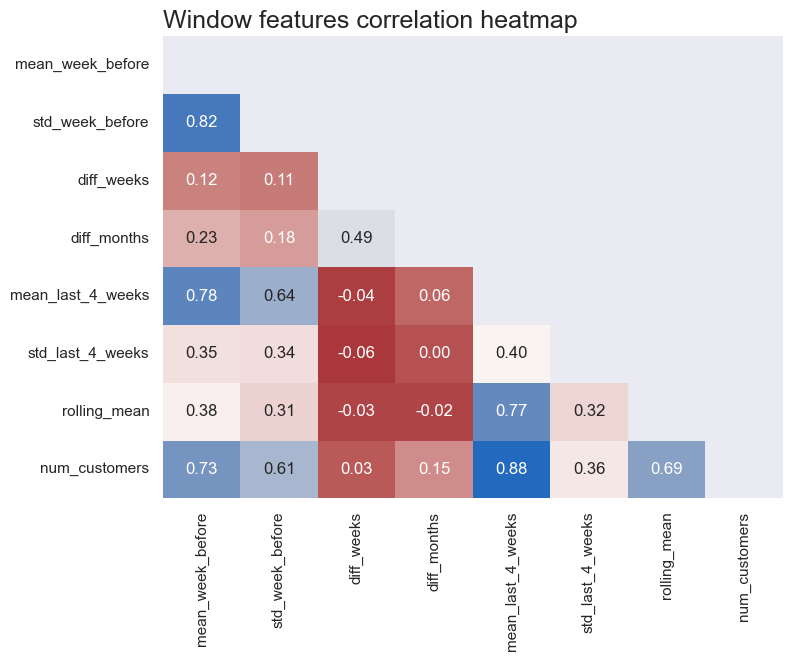

In [143]:
window_features_df = pd.concat([train_df.iloc[:,-7:],train_df.num_customers],axis=1)

# Visualize the correlations with the 
plt.figure(figsize=(8,6))
mask = np.triu(np.ones_like(window_features_df.corr(), dtype=bool))
sns.heatmap(window_features_df.corr(), annot=True, cmap='vlag_r', fmt='.2f', cbar=False, mask=mask)

plt.title('Window features correlation heatmap', size=18, loc='left')
plt.show()

<div class="alert alert-info" role="alert">
    <span style='font-family:sans-serif'>
        <b>Insights:</b><br>
        <ul>
            We've identified that the mean of the last 4 weeks has the strongest correlation with the number of customers, closely followed by the mean of the week before, the rolling mean, and the standard deviation of the week before. While there is some indication of multicollinearity among these features, in general, they provide substantial and meaningful insights.
<br><br>
With this strategy, we've successfully generated three features that exhibit a very high Pearson correlation, even obtaining one feature with a higher correlation compared to our previously best-performing feature, (lag of 7 days). This signifies a notable improvement in our ability to capture relevant patterns in the data, paving the way for more accurate predictions of customer behavior.
        </ul>
    </span>
</div>

<a id="4"></a>
# <p style="background-color:#052C69;font-family:sans-serif;color:#FFFFFF;font-size:120%;text-align:left;border-radius:12px 12px;"> 4. Data Preprocess</p>

Let's create a pìpeline for the entire preprocessing steps

**For time series models**

In [144]:
df_ts = train_final.copy() 

# Convert custom functions into transformers
reformat_t = FunctionTransformer(reformat)
service_closed_t = FunctionTransformer(service_closed)
outliers_t = FunctionTransformer(outliers_treatment)

# Create a pipeline
pipe_timeseries = make_pipeline(
                                reformat_t,
                                service_closed_t,
                                outliers_t
                                )

df_ts = pipe_timeseries.fit_transform(df_ts)

# Dataset including all the data
df_ts_all = df_ts.num_customers
df_ts_capped = df_ts.query('index.dt.year > 2019').num_customers # Excluding 2019

**Let's take a look**

In [145]:
df_ts_capped.tail(7)

date
2023-09-18     99
2023-09-19    112
2023-09-20    171
2023-09-21    142
2023-09-22    182
2023-09-23    204
2023-09-24    200
Name: num_customers, dtype: int64

## 4.1 Time Series Cross Validation


We're incorporating an 8-week testing phase within the time series cross-validation.

In [146]:
n_splits=8
tss = TimeSeriesSplit(n_splits=n_splits, test_size=7)

**Let's plot the peiods**

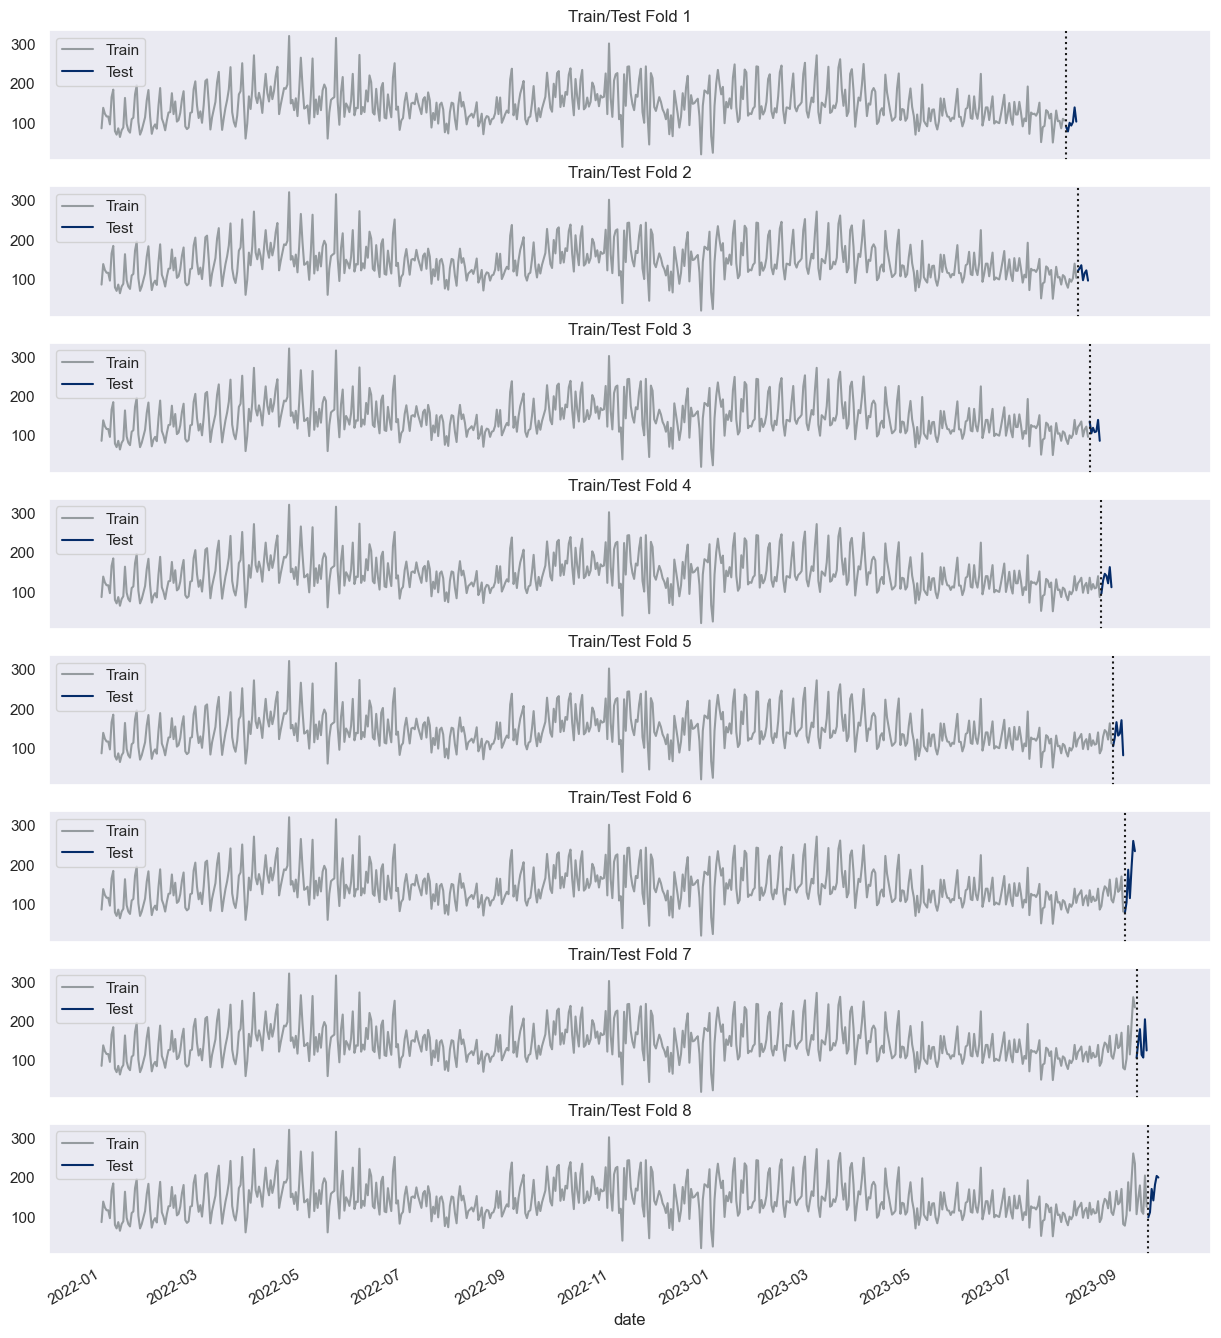

In [147]:
fig, ax = plt.subplots(n_splits,1, figsize=(15,18), sharex=True)

for i, (train_idx, val_idx) in enumerate(tss.split(df_ts_capped)):
    train = df_ts_capped.iloc[train_idx]
    test = df_ts_capped.iloc[val_idx]
    train.plot(ax=ax[i], color='#959b9f',
               title=f'Train/Test Fold {i+1}',
               label='Training data')
    test.plot(ax=ax[i], 
              color='#052C69',
              label='Test data')
    ax[i].legend(['Train', 'Test'], loc='upper left')
    ax[i].axvline(test.index.min(), color='k', ls=':')

plt.show()

**Some functions for further use**

In [148]:
def plot_results(df, avg_mae, median_mae, title):
    # Plot the residuals
    fig, ax = plt.subplots(2, figsize=(12,7), sharex=True)
    df['residuals'].plot(ax=ax[0], linewidth=2)
    ax[0].set_title(f'Residuals Fluctuation | Absolute Error: Mean {avg_mae:.2f} & Median: {median_mae:.2f}', loc='left', size=18)
    ax[0].legend(loc='upper left')
    # Plot the predictions vs. real
    df['real'].plot(ax=ax[1], color='#A3A3A3', linewidth=2, label='Real')
    df['predictions'].plot(ax=ax[1], color='#10717a', linewidth=1.5, label='Predictions')
    ax[1].set_title('Number of customers: Real vs. Predicted', loc='left', size=18)
    ax[1].legend()

    plt.suptitle(title, size=24)
    plt.tight_layout()

def plot_feature_importance(model, columns, title):
    feature_importance =  pd.Series(model.feature_importances_, index=columns).sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(14,3))
    feature_importance.plot(kind='bar',
                        ax=ax,
                        color= sns.color_palette('Blues_r',len(feature_importance)))
    ax.set_title(f'Feature Importance {title}', loc='left', size=20)
    
def explore_residuals(residuals, model):
    fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
    
    lags = 20
    
    if len(residuals)/2 < lags:
        lags = len(residuals)/2 - 1

    plot_acf(residuals, lags=lags, ax=ax[0], title=None)
    ax[0].set_title('ACF Residuals', loc='left', size=16)

    plot_pacf(residuals, lags=lags, ax=ax[1], title=None)
    ax[1].set_title('PACF Residuals', loc='left', size=16)
    
    plt.suptitle(f'Explore residuals for {model}', size=20)
    plt.tight_layout()
    return fig
    
def convert_into_df(array, index, pipe, other_columns=None):
    ohe_transformer = pipe.named_steps['columntransformer'].named_transformers_['onehotencoder']
    ohe_column_names = ohe_transformer.get_feature_names_out().tolist()
    
    if other_columns is not None:
        columns =  ohe_column_names +  other_columns
    else:
        columns = ohe_column_names

    df = pd.DataFrame(array, columns=columns, index=index)
    return df

def encoding(df, pipe, cols):
    encoder = pipe.named_steps['columntransformer'].named_transformers_['onehotencoder']
    ohe_cols = encoder.transform(df[cols])
    ohe_names = encoder.get_feature_names_out()
    ohe_df = pd.DataFrame(ohe_cols, columns=ohe_names, index=df.index)
    df.drop(cols, axis=1, inplace=True)
    cols_names = ohe_names.tolist() + df.columns.tolist()
    df = pd.concat([ohe_df, df], axis=1, ignore_index=True)
    df.columns = cols_names
    return df

<a id="5"></a>
# <p style="background-color:#052C69;font-family:sans-serif;color:#FFFFFF;font-size:120%;text-align:left;border-radius:12px 12px;"> 5. Modeling</p>

## 5.1 Original previsions

The initial step involves computing the error in the company's initial predictions, as previously mentioned. This serves as our benchmark for evaluation.


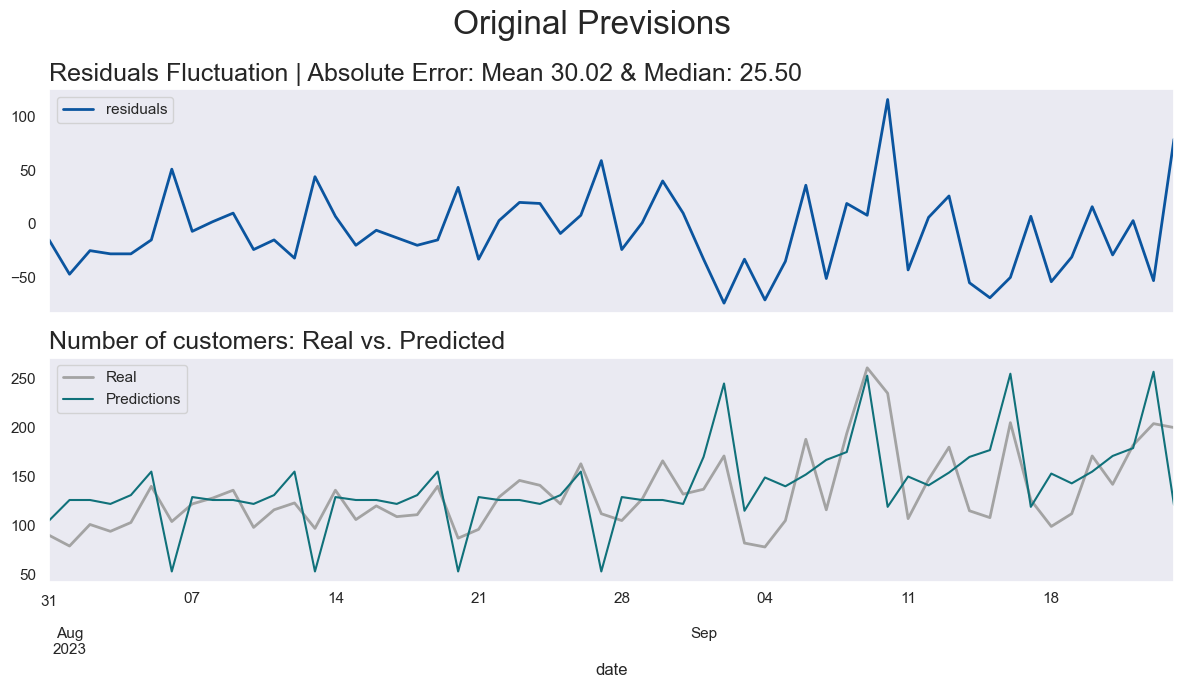

In [149]:
# Reformat the previsions dataset
rename_columns = {'CLIENTES_AM':'customers_am','CLIENTES_PM':'customers_pm', 'CLIENTES_TOTAL':'num_customers'}
previsions['FECHA'] = pd.to_datetime(previsions['FECHA'], format='%d/%m/%Y')
previsions_series = previsions.set_index('FECHA').rename(columns=rename_columns)['num_customers']
previsions_series = previsions_series.loc['2023-07-31':'2023-09-24']

# Same days as in the previsions dataset
real = df_ts[df_ts.index.isin(previsions_series.index)]['num_customers']
residuals = real - previsions_series # residuals

# Comparative dataframe
results_previsions = pd.DataFrame({'real': real, 
                        'predictions': previsions_series, 
                        'residuals': residuals}, 
                        index= real.index)

avg_ae = np.abs(results_previsions.residuals).mean()
median_ae = np.abs(results_previsions.residuals).median()

plot_results(results_previsions, avg_ae, median_ae, 'Original Previsions')
plt.show()

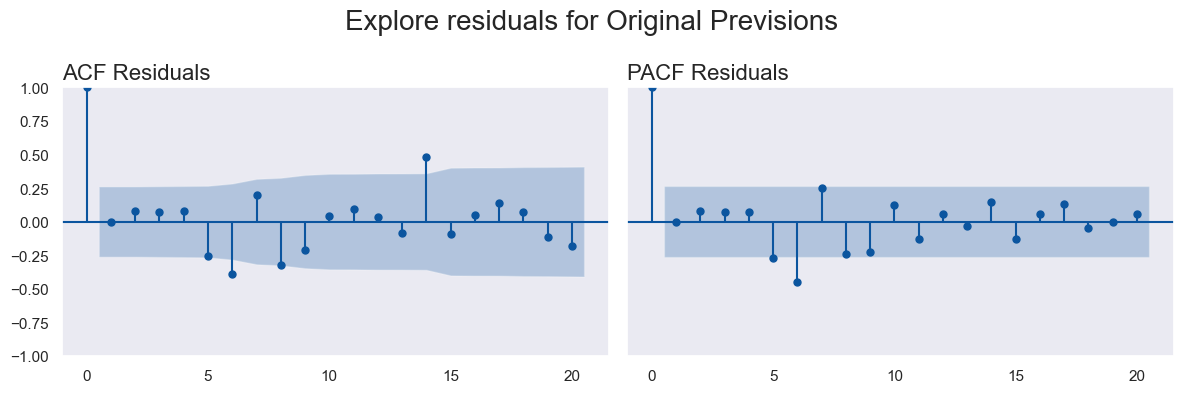

In [150]:
explore_residuals(results_previsions.residuals, 'Original Previsions')
plt.show()

## 5.2 Simple Exponential Smoothing (ETS)

In [151]:
mae = []
predictions_ets = []

for train_idx, val_idx in tss.split(df_ts_capped):
    train = df_ts_capped.iloc[train_idx]
    test = df_ts_capped.iloc[val_idx]

    ets = ETSModel(
        train,
        error="add",
        trend="add",
        seasonal="add",
        seasonal_periods=7
    )
    fit = ets.fit()

    forecasts = fit.forecast(7)
    predictions_ets.append(forecasts.values)

predictions_ets = np.concatenate(predictions_ets).astype(int)
results_ets = pd.DataFrame({'real': real, 
                                'predictions': predictions_ets}, 
                                index=real.index)

results_ets['residuals'] = results_ets.real - results_ets.predictions
avg_ae_ets = np.abs(results_ets.residuals).mean()
median_ae_ets = np.median(np.abs(results_ets.residuals))

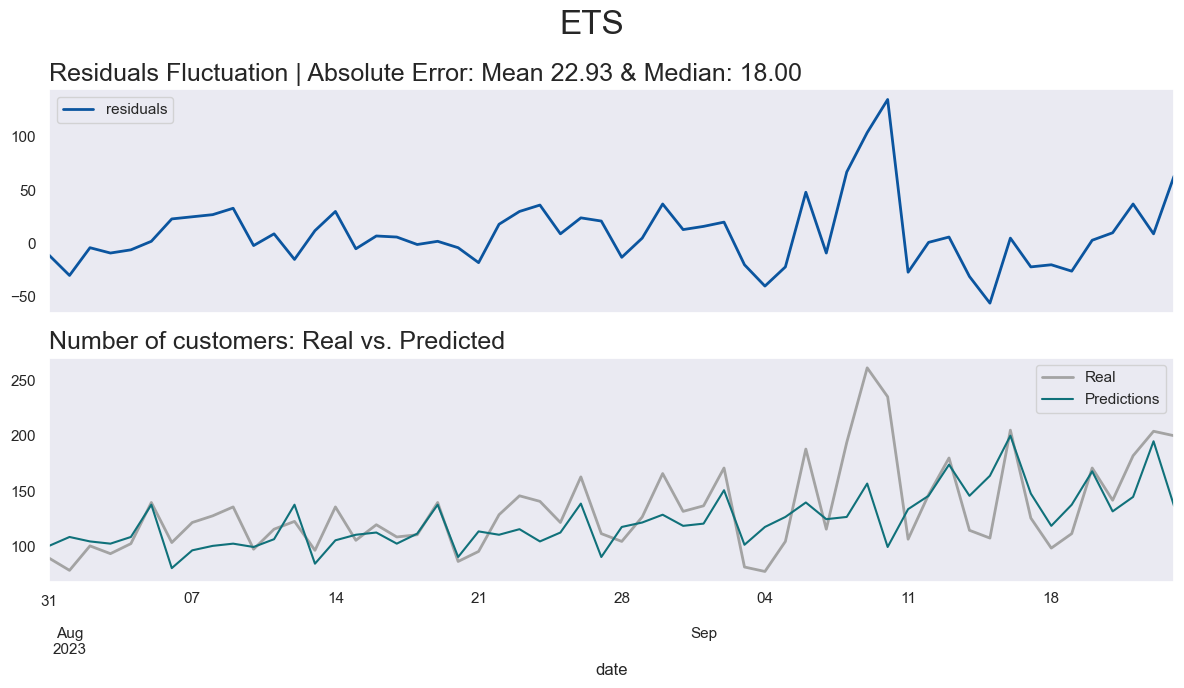

In [152]:
plot_results(results_ets, avg_ae_ets, median_ae_ets, 'ETS')
plt.show()

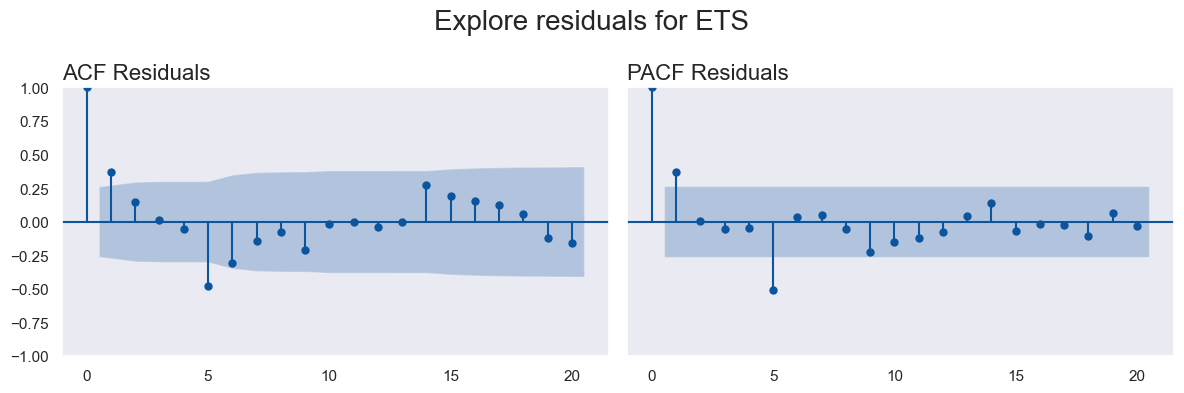

In [153]:
explore_residuals(results_ets.residuals, 'ETS')
plt.show()

## 5.3 STL & AutoRregresive Moving Average

In [154]:
best_mae = float('inf')
best_order = None
results_stl_arma = pd.DataFrame(columns=['p', 'q', 'avg_MAE','median_MAE'])

# Explore all possible combinations of the list created before
for q in q_exc:
    for p in p_exc:
        mae = []
        predictions = []
        for train_idx, val_idx in tss.split(df_ts_capped):
            train = df_ts_capped.iloc[train_idx]
            test = df_ts_capped.iloc[val_idx]

            stlf = STLForecast(train, SARIMAX, 
                                model_kwargs={'order':(p,0,q)}, 
                                period=7, 
                                robust=False)       
            res = stlf.fit()
            forecasts = res.forecast(7)

            mae.append(np.mean(np.abs(test.values - forecasts)))
            predictions.append(forecasts)
        else:
            predictions = np.concatenate(predictions).astype(int)
            median_ae = np.median(np.abs(real - predictions))
            avg_ae = np.mean(np.abs(real - predictions))
            result = pd.DataFrame({'p': [p], 'q': [q], 'avg_MAE': [avg_ae], 'median_MAE': [median_ae]})
            results_stl_arma = pd.concat([results_stl_arma,result], ignore_index=True)

            if avg_ae < best_mae:
                best_mae = avg_ae
                mae_folds = mae
                best_order = (p,0,q)

                # Store the results for the best model in a df
                results_arma = pd.DataFrame({'real': real, 'predictions': predictions}, index=real.index)
                results_arma['residuals'] = results_arma.real - results_arma.predictions
                median_ae = np.median(np.abs(results_arma.residuals))

results_stl_arma.sort_values(by='avg_MAE')[:10]

,p,q,avg_MAE,median_MAE
0,1,1,25.392857,20.5
2,14,1,25.428571,21.0
4,6,6,25.714286,21.5
9,1,14,25.964286,21.0
7,6,7,26.625000,21.0
11,14,14,27.142857,21.0
8,14,7,27.214286,20.5
10,6,14,27.232143,21.5
5,14,6,27.500000,21.0
3,1,6,27.785714,23.0


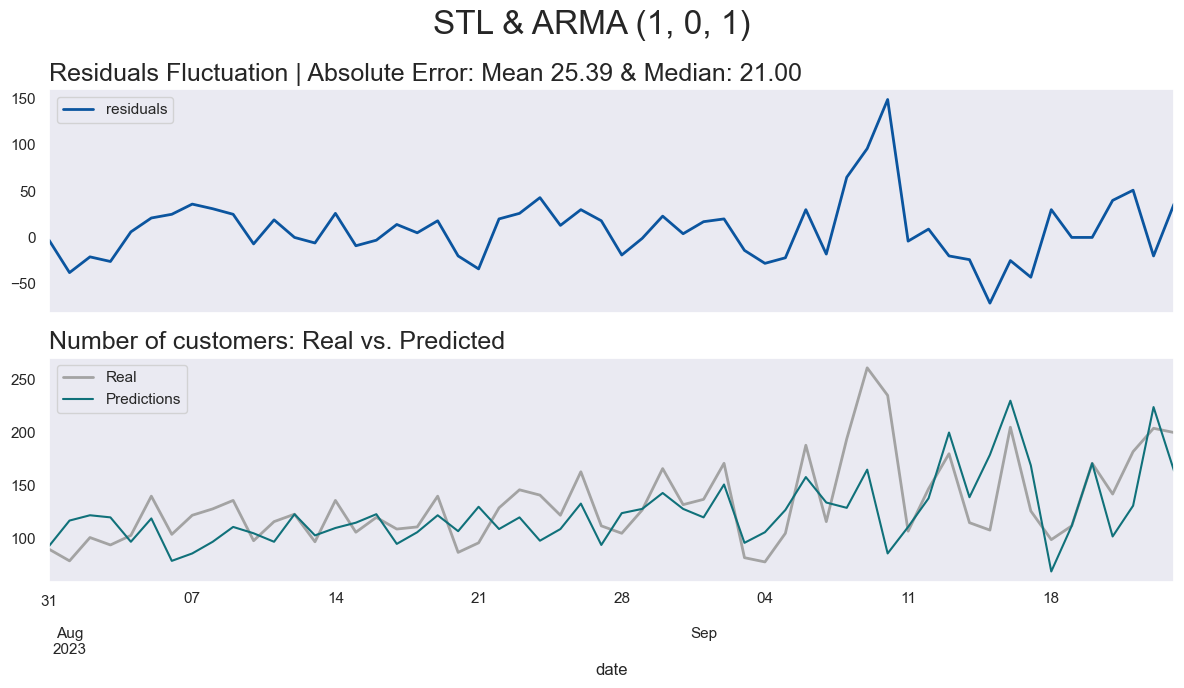

In [155]:
plot_results(results_arma, best_mae, median_ae, f'STL & ARMA {best_order}')
plt.show()

## 5.4 SARIMA

### 5.4.1 Add other preprocessing steps for SARIMA

In [156]:
ohe = OneHotEncoder(drop='first', sparse_output=False)

# Copy of the original df excluding 2019 & days with zero customers
df_sarima = train_final.loc[(~train_final.FECHA.str.contains('2019')) &
                            (train_final.CLIENTES_TOTAL != 0)].copy() 
index_sarima = df_sarima.index

# More custom functions to transformers
time_features = FunctionTransformer(temporal_features)
season_column = FunctionTransformer(add_season_column)

# Column  transformer
ct_ts = make_column_transformer(
                                (ohe,['dayofweek','season']),
                                ('passthrough',['num_customers']),
                                remainder='drop')

# Add more steps to the original pipeline
pipe_ts = make_pipeline(pipe_timeseries,
              time_features,
              season_column,
              ct_ts
             )

array_sarima = pipe_ts.fit_transform(df_sarima)

train_sarima = convert_into_df(array=array_sarima,  
                                  index=index_sarima,
                                  pipe=pipe_ts,
                                  other_columns=['num_customers'])
train_sarima.head()

,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,season_1,season_2,season_3,num_customers
364,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,87.0
365,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,139.0
366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,124.0
367,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,117.0
368,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,117.0



* After a thorough iteration, we strategically introduced additional exogenous features—such as season and day of the week dummies—to enhance the model's performance.

### 5.4.2 Modeling

In [157]:
best_mae = float('inf')
best_order = None

exog_features = train_sarima.drop('num_customers', axis=1)
target = train_sarima['num_customers']

mae = []
predictions = []
test_df = pd.Series([])

for train_idx, val_idx in tss.split(train_sarima):
    train = target.iloc[train_idx]
    test = target.iloc[val_idx]
    exog_train = exog_features.iloc[train_idx]
    exog_test = exog_features.iloc[val_idx]

    order = (1,1,1)
    seasonal_order = (6,0,6,7)
    model = SARIMAX(train, 
                    order=order, 
                    seasonal_order=seasonal_order,
                   exog=exog_train
                   )
    res = model.fit()
                        
    forecasts = res.forecast(7, exog=exog_test)
    predictions.append(forecasts)
    
    test_df = pd.concat([test_df, test], ignore_index=True)
    
predictions = np.concatenate(predictions).astype(int)
results_sarima = pd.DataFrame({'real': real.values, 
                               'predictions': predictions}, 
                                index=test_df.index
                           )
results_sarima['residuals'] = results_sarima.real - results_sarima.predictions
avg_ae_sarima = np.mean(np.abs(results_sarima.residuals))
median_ae_sarima = np.median(np.abs(results_sarima.residuals))

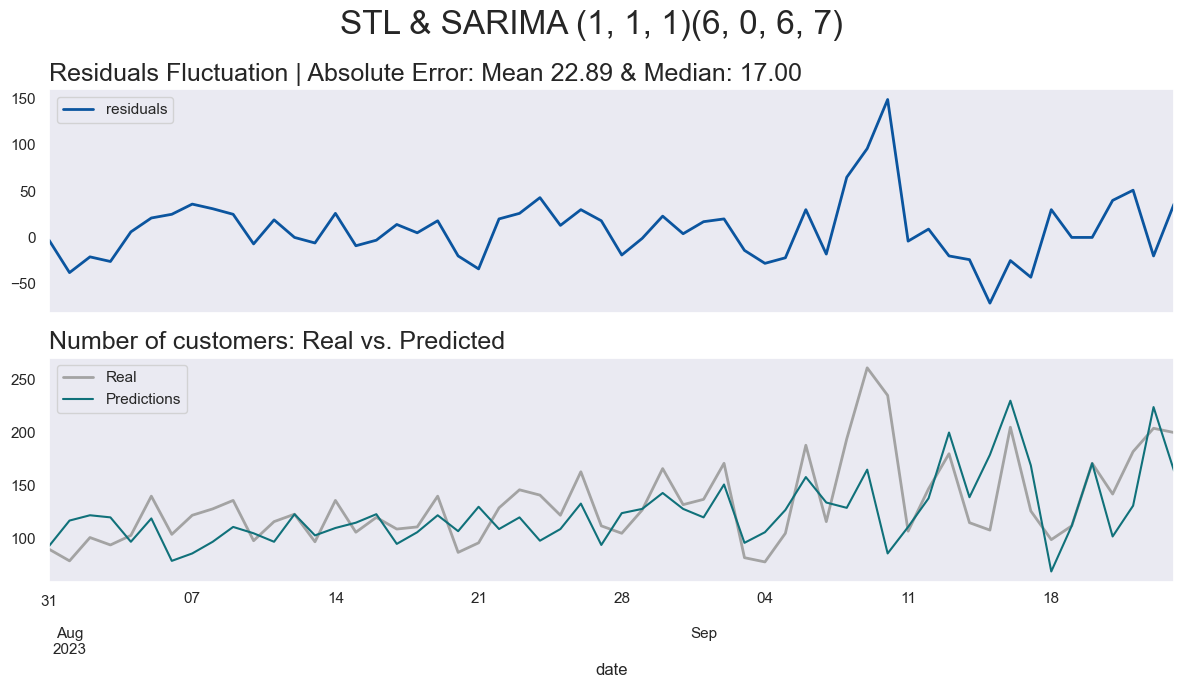

In [158]:
plot_results(results_arma, avg_ae_sarima, median_ae_sarima, f'STL & SARIMA {order}{seasonal_order}')
plt.show()

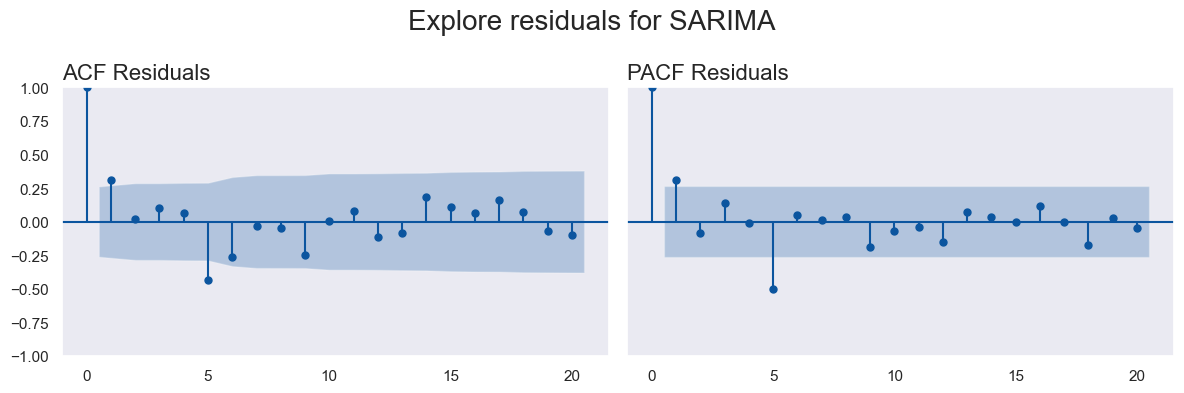

In [159]:
explore_residuals(results_sarima.residuals, 'SARIMA')
plt.show()

## 5.5 XGBoost

Transitioning to a machine learning model like XGBoost marks a shift from traditional statistical approaches. This change allows us to leverage the strengths of advanced algorithms, particularly focusing on feature selection and fine-tuning for better forecasting accuracy.

We're going to leverage insights from our EDA to select impactful features. Our focus is on fine-tuning the model through cross-validation, aiming to balance complexity without overfitting. 

### 5.5.1 Data Preparation for XGBoost

In [160]:
df_xgb = train_final.copy()
date_df = df_xgb.loc[df_xgb['CLIENTES_TOTAL'] != 0,'FECHA'] # Excluding days with zero customers
index_xgb = pd.to_datetime(date_df, format='%d/%m/%Y')

# Convert custom functions
lag_features_t = FunctionTransformer(lag_features)
window_features_t = FunctionTransformer(window_features)
day_features_t = FunctionTransformer(day_features)

# Column Transformer
ohe = OneHotEncoder(sparse_output=False)

ohe_columns = ['dayofweek','season','month']
pass_columns = ['mean_last_4_weeks','lag_7_days','mean_week_before','rolling_mean',
                'lag_13_days','lag_84_days','one_service_closed','num_customers']

ct = make_column_transformer(
                            (ohe,ohe_columns),
                            ('passthrough', pass_columns),
                            remainder='drop'
                            )

# Create another pipeline for XGBoost
pipeline_xgb = make_pipeline(
              reformat_t,
              service_closed_t,
              time_features,
              season_column,
              lag_features_t,
              window_features_t,
              day_features_t,
              ct,
              )

# Fit & Transform the data
df_xgb = pipeline_xgb.fit_transform(df_xgb)

**Let's take a look**

In [161]:
df_xgb = convert_into_df(df_xgb, index_xgb, pipeline_xgb, other_columns=pass_columns)
df_xgb.tail(7)

,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,season_0,season_1,season_2,season_3,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,mean_last_4_weeks,lag_7_days,mean_week_before,rolling_mean,lag_13_days,lag_84_days,one_service_closed,num_customers
FECHA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-09-18,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,96.50,107.0,141.14,157.836879,105.0,122.0,0.0,99.0
2023-09-19,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,127.00,147.0,141.14,159.702128,188.0,151.0,0.0,112.0
2023-09-20,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,170.00,180.0,141.14,177.085714,116.0,112.0,0.0,171.0
2023-09-21,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,126.00,115.0,141.14,178.978723,194.0,96.0,0.0,142.0
2023-09-22,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,140.25,108.0,141.14,227.574468,261.0,154.0,0.0,182.0
2023-09-23,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,200.00,205.0,141.14,270.063380,235.0,122.0,0.0,204.0
2023-09-24,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,138.75,126.0,141.14,164.262411,107.0,122.0,0.0,200.0


### 5.5.2 Modeling

In [162]:
mae = []
results_xgb = pd.DataFrame(columns=['Real', 'Predictions', 'Residuals'])
X_test_xgb = pd.DataFrame()
test_df = pd.DataFrame([])
y_ = pd.DataFrame([])

for fold, (train_idx, val_idx) in enumerate(tss.split(df_xgb)):
        train = df_xgb.iloc[train_idx]
        test = df_xgb.iloc[val_idx]

        # Separate X and Y
        X_train = train.drop('num_customers', axis=1)
        y_train = train.loc[:,'num_customers']
        X_test = test.drop('num_customers', axis=1)
        y_test = test.loc[:,'num_customers']

        reg_xgb = xgboost.XGBRegressor(base_score=10, 
                            booster='gbtree',    
                            n_estimators=5000,
                            early_stopping_rounds=50,
                            objective='reg:squarederror',
                            min_child_weight=5,
                            colsample_bytree=0.75,
                            sampling_method='uniform',
                            eval_metric='rmse',
                            tree_method='gpu_hist',
                            eta=0.01,
                            max_depth=4, 
                            reg_lambda=2,
                            reg_alpha=1,
                            seed=42
                            )

        print('Results for train/test fold number: ',fold+1)
        reg_xgb.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=250)

        y_pred = reg_xgb.predict(X_test)
        mae.append(np.mean(np.abs(y_test-y_pred)))
        residuals = np.array(y_test) - y_pred
        X_test_xgb = pd.concat([X_test_xgb,X_test], ignore_index=True)
        results_xgb = pd.concat([results_xgb,
                                 pd.DataFrame({'real': np.array(y_test), 
                                            'predictions':y_pred, 
                                            'residuals':residuals})],
                                            axis=0, ignore_index=True)
        
        y_ = pd.concat([y_, y_test], ignore_index=True)
        test_df = pd.concat([test_df, X_test], ignore_index=True)

results_xgb = pd.concat([X_test_xgb, results_xgb], axis=1)
test_df = pd.concat([test_df, y_], axis=1)

avg_abserr_xgb = np.mean(np.abs(results_xgb.residuals))
median_abserr_xgb = np.median(np.abs(results_xgb.residuals))
       
print('\nMAE in each fold:\n',{i:j for i, j in zip(np.arange(1,9),np.round(mae,2))})

Results for train/test fold number:  1
[0]	validation_0-rmse:202.61023	validation_1-rmse:92.15357
[234]	validation_0-rmse:40.22111	validation_1-rmse:15.02722
Results for train/test fold number:  2
[0]	validation_0-rmse:202.01353	validation_1-rmse:106.89922
[250]	validation_0-rmse:38.34462	validation_1-rmse:17.45792
[500]	validation_0-rmse:29.93005	validation_1-rmse:14.59717
[588]	validation_0-rmse:29.19056	validation_1-rmse:14.74027
Results for train/test fold number:  3
[0]	validation_0-rmse:201.47876	validation_1-rmse:105.86968
[250]	validation_0-rmse:38.25240	validation_1-rmse:17.34863
[500]	validation_0-rmse:29.85654	validation_1-rmse:13.46864
[750]	validation_0-rmse:27.95427	validation_1-rmse:12.66676
[1000]	validation_0-rmse:26.11675	validation_1-rmse:12.02406
[1033]	validation_0-rmse:25.90062	validation_1-rmse:12.10377
Results for train/test fold number:  4
[0]	validation_0-rmse:200.94668	validation_1-rmse:120.58888
[250]	validation_0-rmse:38.30916	validation_1-rmse:29.37063
[50

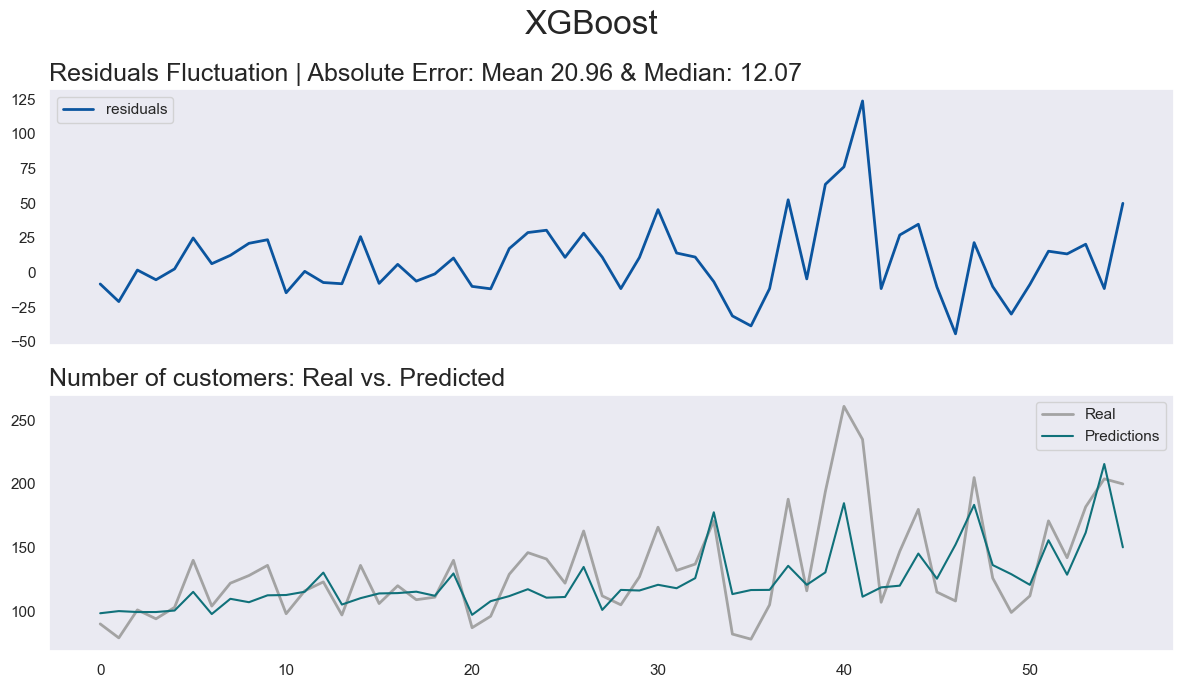

In [163]:
plot_results(results_xgb, avg_abserr_xgb, median_abserr_xgb, 'XGBoost')
plt.show()

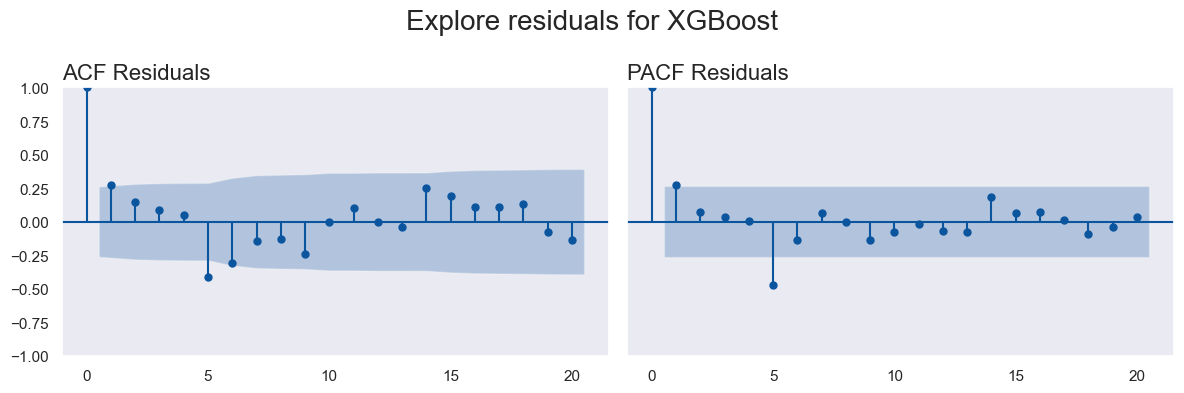

In [164]:
explore_residuals(results_xgb.residuals, 'XGBoost')
plt.show()

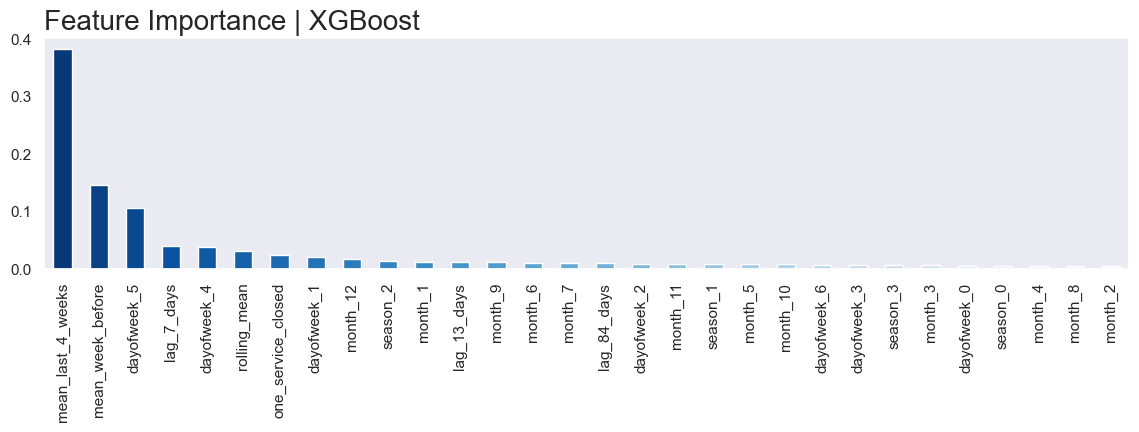

In [165]:
plot_feature_importance(reg_xgb, X_train.columns, '| XGBoost')
plt.show()



<div class="alert alert-warning" role="alert">
    <span style='font-family:sans-serif'>
        <b>Conclusions:</b><br>
        <ul>
            After fine-tuning and feature selection, XGBoost emerged as the top-performing model in our undisclosed process. We used time series cross-validation, a scikit-learn pipeline, and careful feature engineering to maintain data integrity.<br><br>Although achieving satisfactory results, ACF and PACF plots across all models hint at room for improvement, showing correlation in certain periods, signaling a potential for refining the models for better predictive performance.
        </ul>
    </span>
</div>

<a id="6"></a>
# <p style="background-color:#052C69;font-family:sans-serif;color:#FFFFFF;font-size:120%;text-align:left;border-radius:12px 12px;">6. Generate predictions</p>

Let's craft a function that can dynamically generate the required data for model training and predictions. This approach simulates a real-world scenario by mimicking the conditions under which the XGBoost model was initially trained. The goal is to evaluate the model's performance in a practical environment, comparing its predictions against a designated test dataset that was set aside at the project's outset. This setup allows us to gauge how well the model generalizes to unseen data, providing valuable insights into its real-world effectiveness.

In [166]:
def generate_df_predictions(start_date, end_date, past_df, pipeline, one_service_closed=None):
    def generate_df(start_date, end_date, past_df, one_service_closed=None):
        # Generate the dataframe
        index_pred = pd.date_range(start=start_date, end=end_date, freq='d')
        pred = pd.DataFrame(index=index_pred)

        # Fulfill the dataframe

        # -------------------- Lag Features ----------------------------
        time_map = past_df['num_customers'].to_dict()
        pred['lag_7_days'] = (pred.index - pd.Timedelta('7 days')).map(time_map)
        pred['lag_13_days'] = (pred.index - pd.Timedelta('13 days')).map(time_map)
        pred['lag_14_days'] = (pred.index - pd.Timedelta('14 days')).map(time_map)
        pred['lag_21_days'] = (pred.index - pd.Timedelta('21 days')).map(time_map)
        pred['lag_28_days'] = (pred.index - pd.Timedelta('28 days')).map(time_map)
        pred['lag_84_days'] = (pred.index - pd.Timedelta('84 days')).map(time_map)

        # -------------------- Time features ----------------------------
        pred['dayofweek'] = pred.index.dayofweek
        pred['month'] = pred.index.month
        pred = add_season_column(pred) # Season column

        # -------------------- Window features --------------------------
        past_df['date_temp'] = past_df.index
        past_df['week_number'] = past_df['date_temp'].apply(number_of_week)
        past_df['dayofweek_temp'] = past_df.index.dayofweek
        pred['date_temp'] = pred.index
        pred['week_number'] = pred['date_temp'].apply(number_of_week)
        pred['week_before'] = pred['date_temp'] - timedelta(days=7)
        pred['week_number_before'] = pred.week_number - 1

        # Rolling Mean
        df_grouped = past_df.groupby('dayofweek_temp')['num_customers']
        rolling_mean = df_grouped.expanding().mean().reset_index(level=0, drop=True)
        rolling_mean.name = 'rolling_mean'
        pred = pred.merge(rolling_mean, how='left',right_index=True, left_on='week_before')
        pred.index = index_pred

        # Stats last 4 weeks
        pred['mean_last_4_weeks'] = pred.loc[:,['lag_7_days','lag_14_days','lag_21_days','lag_28_days']].mean(1).round(2)

        # Stats week before
        weekly_stats = past_df.groupby('week_number')['num_customers'].agg(['mean', 'std']).round(2)
        pred = pred.merge(weekly_stats, how='left', left_on='week_number_before', right_on='week_number')
        pred = pred.rename(columns={'mean':'mean_week_before', 'std':'std_week_before'})
        pred.index = index_pred

        # Drop unnecesary columns
        cols = ['date_temp','week_number','week_before',
                'week_number_before','lag_14_days','lag_28_days',
                'lag_21_days']
        pred.drop(cols, axis=1, inplace=True)
        past_df.drop(['date_temp','week_number','dayofweek_temp'], axis=1, inplace=True)

        # --------------------- Other features ----------------------------
        pred['one_service_closed'] = np.zeros(len(pred))

        if one_service_closed is not None:
            pred['one_service_closed'] = np.where(pred.index.isin(one_service_closed),1,0)
        else:
            pass

        return pred

    df_pred = generate_df(start_date,end_date,past_df) # Generate the dataframe
    df_pred = encoding(df_pred,pipeline,['dayofweek','season','month']) # Apply the onehotencoder
    order_cols = df_xgb.drop('num_customers', axis=1).columns.tolist() 
    df_pred = df_pred[order_cols] # Reorder columns in the same order that in 
    
    return df_pred

**Let's see how it works**

In [167]:
generate_df_predictions(start_date='2023-07-31',
                        end_date='2023-08-06',
                        past_df=df_ts,
                        pipeline=pipeline_xgb)

,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,season_0,season_1,season_2,season_3,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,mean_last_4_weeks,lag_7_days,mean_week_before,rolling_mean,lag_13_days,lag_84_days,one_service_closed
2023-07-31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,116.00,93,105.86,160.604478,93,98,0.0
2023-08-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,118.50,132,105.86,161.917910,133,92,0.0
2023-08-02,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,113.50,105,105.86,178.609023,129,138,0.0
2023-08-03,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,116.50,106,105.86,182.320896,112,105,0.0
2023-08-04,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,108.00,87,105.86,232.813433,124,134,0.0
2023-08-05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,145.00,111,105.86,275.155556,51,135,0.0
2023-08-06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,70.75,107,105.86,166.552239,93,99,0.0


## 6.1 Evaluate predictions against test dataset

Now, with the test dataset left untouched from the start, we're mimicking a real-world scenario. Here's the rundown:

1. We'll iterate through each week in the test dataset.
2. At each iteration, we use our prediction function, aligning with the week's start and end in the test set, leveraging the past dataset.
3. Applying our XGBoost model, we forecast for the upcoming week.
4. Results for the test dataset and predictions cozy up in the same dataframe for a comprehensive evaluation.
5. The "new week" is gracefully concatenated to the "past week," transforming our dataframe for the next iteration.
6. Rinse and repeat from steps 2 to 5.

In [168]:
test_weeks = test_final['FECHA'].count()/7
past_df = df_xgb.copy()
past_df_raw = train_final.copy()

# Dataframes for further storing
results_test = pd.DataFrame(columns=['real','predictions'])
X_test_df = pd.DataFrame([])
y_test_df = pd.DataFrame([])

i = 0
j = 7
for week in np.arange(test_weeks):
    # Separate weeks
    print(f'Week number {week+1:.0f}:')
    new_week = test_final[i:j].copy()   
    new_week['FECHA'] = pd.to_datetime(new_week['FECHA'], format='%d/%m/%Y')
    start_week = new_week.iloc[0,1]
    end_week = new_week.iloc[6,1]
    
    # Generate predictions
    y_test = new_week['CLIENTES_TOTAL']
    X_test = generate_df_predictions(start_week,end_week,past_df,pipeline_xgb)
    y_train = past_df['num_customers']
    X_train = past_df.drop('num_customers', axis=1)
    
    reg_xgb.fit(X_train, y_train,
               eval_set=[(X_train,y_train)],
               verbose=250)
    
    y_pred = reg_xgb.predict(X_test)
    
    # Store X, Y and results
    X_test_df = pd.concat([X_test_df, X_test], ignore_index=True)
    y_test_df = pd.concat([y_test_df, y_test], ignore_index=True)
    
    temp_df = pd.DataFrame({'real': y_test, 'predictions':y_pred})
    results_test = pd.concat([results_test, temp_df], ignore_index=True)
    
    # Transform and add the week to the past dataframe
    past_df_raw = pd.concat([past_df_raw, new_week], ignore_index=True)
    index = pd.to_datetime(past_df_raw.loc[past_df_raw['CLIENTES_TOTAL'] != 0,'FECHA'], format='%d/%m/%Y')
    past_df = past_df_raw.copy()
    
    past_df = pipeline_xgb.fit_transform(past_df)
    past_df = convert_into_df(past_df, index, pipeline_xgb, other_columns=pass_columns)

    i += 7
    j += 7
    
test = pd.concat([X_test_df, y_test_df], axis=1, ignore_index=True)
cols_test = X_test_df.columns.tolist() + ['num_customers']
test.columns = cols_test

Week number 1:
[0]	validation_0-rmse:199.14799
[250]	validation_0-rmse:38.18649
[500]	validation_0-rmse:29.79941
[750]	validation_0-rmse:27.87191
[1000]	validation_0-rmse:26.10250
[1250]	validation_0-rmse:24.32701
[1500]	validation_0-rmse:22.81499
[1750]	validation_0-rmse:21.56347
[2000]	validation_0-rmse:20.42007
[2250]	validation_0-rmse:19.44655
[2500]	validation_0-rmse:18.37970
[2750]	validation_0-rmse:17.46740
[3000]	validation_0-rmse:16.72832
[3250]	validation_0-rmse:15.89934
[3500]	validation_0-rmse:15.21744
[3750]	validation_0-rmse:14.55973
[4000]	validation_0-rmse:14.00612
[4250]	validation_0-rmse:13.38781
[4500]	validation_0-rmse:12.84248
[4750]	validation_0-rmse:12.34077
[4999]	validation_0-rmse:11.84171
Week number 2:
[0]	validation_0-rmse:199.00309
[250]	validation_0-rmse:38.27021
[500]	validation_0-rmse:29.90688
[750]	validation_0-rmse:27.94502
[1000]	validation_0-rmse:26.04028
[1250]	validation_0-rmse:24.47180
[1500]	validation_0-rmse:22.94951
[1750]	validation_0-rmse:21.

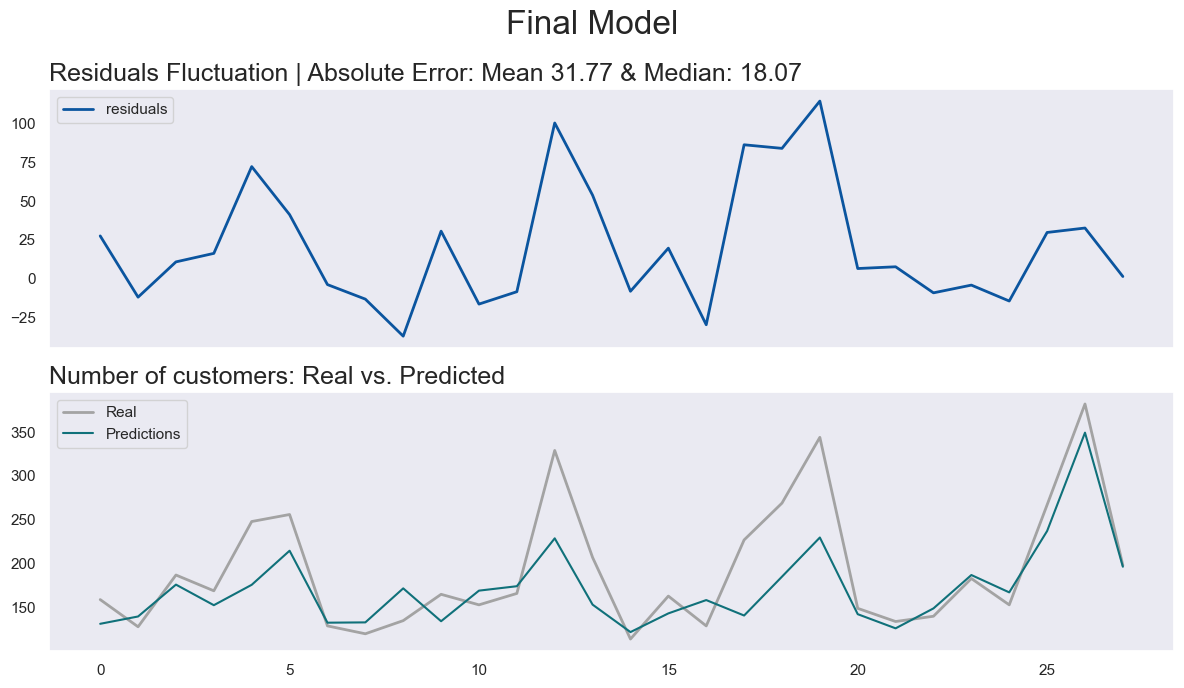

In [169]:
results_test['residuals'] = results_test.real - results_test.predictions
avg_abserr_test = np.mean(np.abs(results_test.residuals))
median_abserr_test = np.median(np.abs(results_test.residuals))

plot_results(results_test, avg_abserr_test, median_abserr_test, 'Final Model')

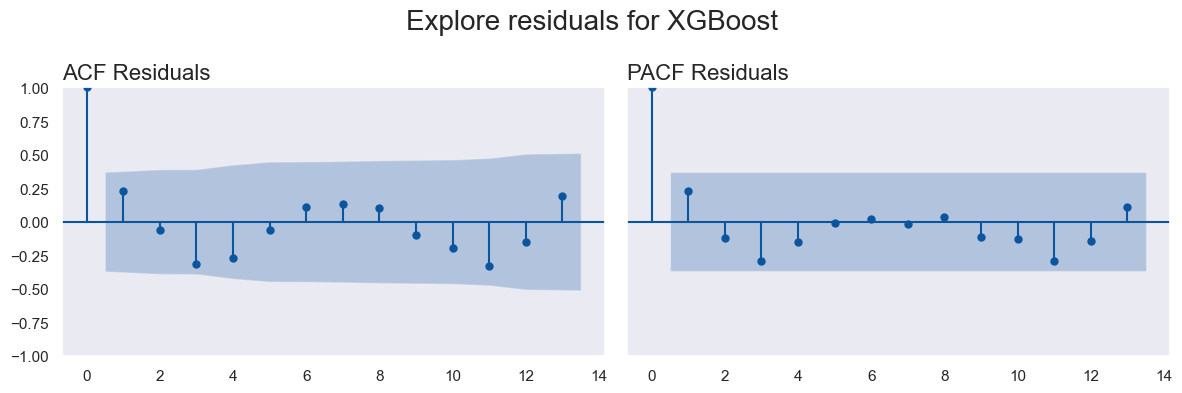

In [170]:
explore_residuals(results_test.residuals, 'XGBoost')
plt.show()

**Original Performance**

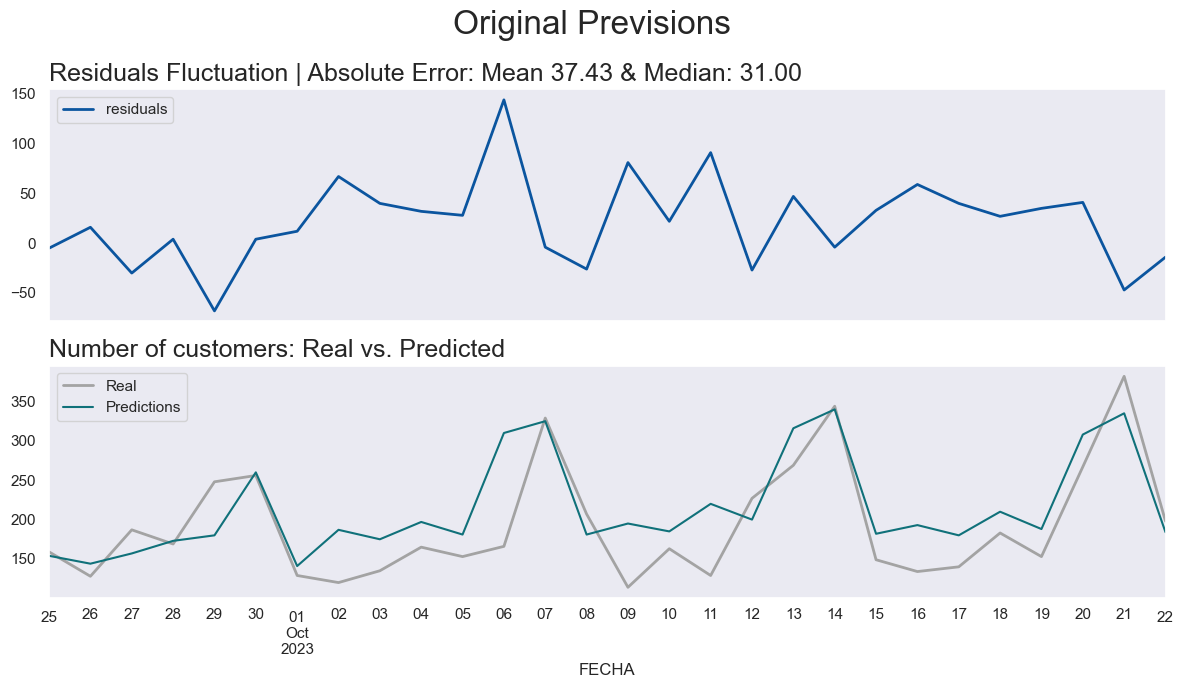

In [171]:
test_final['FECHA'] = pd.to_datetime(test_final['FECHA'], format='%d/%m/%Y')
real = test_final.set_index('FECHA')['CLIENTES_TOTAL']
previsions['FECHA'] = pd.to_datetime(previsions['FECHA'], format='%d/%m/%Y')
previsions_eval = previsions.loc[previsions['FECHA'].isin(real.index)]
previsions_eval = previsions_eval.set_index('FECHA')['CLIENTES_TOTAL']
results_previsions = pd.DataFrame({'predictions': previsions_eval, 'real':real})
results_previsions['residuals'] = results_previsions.predictions - results_previsions.real

avg_mae_previsions = np.mean(np.abs(results_previsions.residuals))
median_mae_previsions = np.median(np.abs(results_previsions.residuals))

plot_results(results_previsions, avg_mae_previsions, median_mae_previsions, 'Original Previsions')

<a id="7"></a>
# <p style="background-color:#052C69;font-family:sans-serif;color:#FFFFFF;font-size:120%;text-align:left;border-radius:12px 12px;">7. Conclusions</p>

While the Mean Absolute Error exhibits a relatively modest 15% improvement, there's a noteworthy 42% enhancement in the Median Absolute Error. Our model adeptly captures nuanced patterns like valleys and weekday behaviors. However, it reveals some challenges in accurately predicting weekend patterns, possibly attributed to the inherent variability in customer interactions during those periods.

Despite acknowledging the need for further refinement in the XGBoost model, it's encouraging to observe a substantial enhancement in the overall predictive accuracy. This advancement holds strategic value for the company, providing a more refined tool for optimizing the weekly purchase budget. This analytical capability allows for more informed and precise adjustments, contributing to better financial planning.

**I trust you have found this analytical journey insightful. Your feedback is highly valued; please feel free to connect with me via my profile at the commencement of this project.**

In [172]:
results_previsions['xgboost'] = results_test.predictions.astype(int).values
results_previsions.drop('residuals', axis=1, inplace=True)
results_previsions

,predictions,real,xgboost
FECHA,,,
2023-09-25,154,159,131
2023-09-26,144,128,139
2023-09-27,157,187,176
2023-09-28,173,169,152
2023-09-29,180,248,175
2023-09-30,260,256,214
2023-10-01,141,129,132
2023-10-02,187,120,132
2023-10-03,175,135,171
